## README

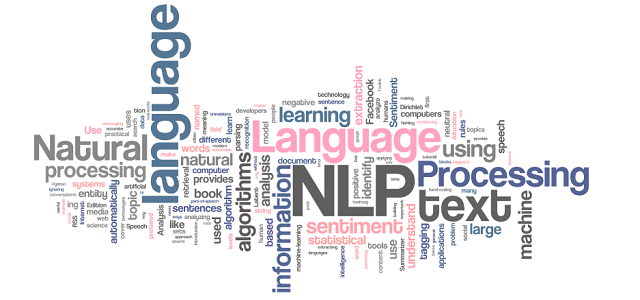

**Procesamiento de Lenguaje Natural para 8 preguntas abiertas**

## ETL DE DATASETS PROPORCIONADOS POR LA EMPRESA

- Por motivos de privacidad, los datasets no están disponibles, pero este fue el código que se utilizó

In [ ]:
#IMPORTAR LIBRERÍAS A UTILIZAR
import pandas as pd
import numpy as np

#### DATASET DE WIX

In [ ]:
#DESCARGA DEL DATASET CON ORIGEN EN PLATAFORMA WIX
data_wix = pd.read_csv('db_Wix.csv', sep=',', encoding="utf8")

In [ ]:
#VISUALIZACIÓN DEL DATASET
data_wix.head(1)

In [ ]:
#Hay muchísimas columnas que no se van a ocupar para la predicción del modelo, prosigo a
#quedarme sólo con las que se necesitan.
data_wix.shape

In [ ]:
#CREANDO DATASET FILTRADO CON LAS COLUMNAS A UTILIZAR
wix_lista = data_wix.iloc[:, [2,3,13,93,25,26,27,28,29,30,31,32]]
wix_lista.head(2)

#### DATASET CON EL SCORE DE LAS PREGUNTAS

In [ ]:
#DESCARGANDO DATASET CON EL SCORE DE LAS PREGUNTAS RESPONDIDAS EN PLATAFORMA WIX
xls = pd.ExcelFile('Credit_score v2.0.xlsx')
df_score = pd.read_excel(xls, 'Raw DB')

In [ ]:
#VISUALIZACIÓN DE LA DATA
df_score.head()

In [ ]:
#VISUALIZACIÓN DE LAS COLUMNAS PARA SELECCIONAR LAS QUE SE VAN A UTILIZAR PARA EL MODELO
columns_name = df_score.columns.values
columns_name

In [ ]:
#CREANDO DATASET FILTRANDO LAS COLUMNAS SELECCIONADAS
# **SE APRECIAN 2 VALORES NULOS IMPORTANTES PARA EL MERGE
score_listo = df_score.iloc[:, [1,2,3,33,34,35,36,37,38,39,40]]
score_listo

In [ ]:
wix_lista['Codigo emprendimiento'].duplicated().sum()

14

In [ ]:
#se buscará en este dataset si está la información requerida, los datos faltantes corresponden a: 
#Allegra Adonai y Watermelon SRL
mask = wix_lista[wix_lista['Nombre de tu emprendimiento'] == 'Allegra Adonai']
mask

** Se observa repetida las casillas para Allegra Adonai, sin embargo, de acuerdo al score del dataset df_score corresponde al index 34, así que el código es 00399

In [ ]:
mask2 = wix_lista[wix_lista['Nombre de tu emprendimiento'] == 'Watermelon S.R.L.']
mask2

In [ ]:
#SE AGREGA LA INFORMACIÓN FALTANTE EN LOS DATOS NULOS DE LA COLUMNA CODIGO
score_listo.iat[0,2] = '480'
score_listo.iat[19,2] = '00399'
score_listo


In [ ]:
#Prosigo a modificar los nombres de las columnas para hacer más fácil la compresión
score_listo.rename({'Preguntas abiertas':'target_1', 'Unnamed: 34':'target_2',
                    'Unnamed: 35':'target_3', 'Unnamed: 36':'target_4', 
                    'Unnamed: 37':'target_5', 'Unnamed: 38':'target_6',
                     'Unnamed: 39':'target_7', 'Unnamed: 40':'target_8', 
                     'Codigo':'Codigo emprendimiento'}, axis=1, inplace=True)
score_listo.head(2)

In [ ]:
#CREANDO DATASET FILTRANDO LAS COLUMNAS SELECCIONADAS
# **SE APRECIAN 2 VALORES NULOS IMPORTANTES PARA EL MERGE
targets = score_listo.iloc[:, [2,3,4,5,6,7,8,9,10]]
targets

In [ ]:
# Confirmación de tipo de dato

wix_lista['Codigo emprendimiento'] = wix_lista['Codigo emprendimiento'].astype('str')
targets['Codigo emprendimiento'] = targets['Codigo emprendimiento'].astype('str')
wix_lista['Codigo emprendimiento'] = wix_lista['Codigo emprendimiento'].str.strip(' ')
targets['Codigo emprendimiento'] = targets['Codigo emprendimiento'].str.strip(' ')

#### Se hace merge tomando en cuenta toda la lista de wix, para pasarlo al área correspondiente y evalue las respuestas

In [ ]:
#Anteriormente visualicé duplicados, prosigo a revisar a fondo el dataset
wix_lista['Codigo emprendimiento'].duplicated().sum()

13

In [ ]:
wix_lista[wix_lista['Codigo emprendimiento'].duplicated()]

In [ ]:
#Se eliminan duplicados en los que el solicitante no terminó de responder, ya que, exite otra
# solicitud con la documentación completa

wix_lista.drop([6,31,93,143,149], axis=0, inplace=True)
wix_lista.shape

C:\Users\nanci\AppData\Local\Temp\ipykernel_15004\3209352072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wix_lista.drop([6,31,93,143,149], axis=0, inplace=True)


(208, 12)

In [ ]:
#Data lista para el merge 
wix_completa = pd.merge(wix_lista, targets, how='left', on='Codigo emprendimiento')
wix_completa

In [ ]:
#PROSIGO A GUARDAR LA DATA EN FORMATO CSV
wix_completa.to_excel('wix_etl.xlsx', index=False, encoding='utf-8')

c:\Users\nanci\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


## PREPARACIÓN DE DATA SINTÉTICA PARA NLP

Estas son las preguntas que se le estará haciendo a la IA, por cómo está configurada la función, se estima que las respuestas estén dentro de score 3

PREGUNTAS:

Explícanos el problema/necesidad/deseo que tu emprendimiento quiere resolver para tus potenciales clientes. Para darle mayor fuerza al aspecto que quieres resolver puedes utilizar algún dato estadístico.

Explícanos la solución que tu emprendimiento ofrece al problema/necesidad/deseo identificado. ¿Cuáles son los productos o servicios que ofreces? ¿Cómo haces llegar tu solución a tus clientes?

¿Cuáles son las características de tu segmento de clientes?

¿Qué te hace diferente a tus competidores? ¿Cuáles son tus fortalezas y debilidades?

¿Cuál es tu propuesta de valor? ¿Qué beneficios le entregas a tus clientes?

¿Cuáles son tus metas a largo plazo?

¿Cómo ves tu emprendimiento en el futuro?

¿Qué riesgos temes correr con tu emprendimiento?

In [ ]:
#Instalación de la librería

pip install openai

In [ ]:
#Importando librería a ocupar con clave privada
import openai
import os

''' Puedes encontrar tu Secret API key in your User settings. '''

openai.api_key = 'YOUR_SECRET_API_KEY'

In [ ]:
#Función para obtener una respuesta

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]  #Asignamos un rol (seremos un usuario) y en el prompt incluiremos las indicaciones claras y precisas
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0.3, # Es el nivel de creatividad de la IA en sus respuestas, a mayor grado, mayor aletoriedad
    )
    return response.choices[0].message["content"] #Se obtiene una respuesta en formato JSON, se accede a la respuesta mediante los índices

In [ ]:
# Se le dan las indicaciones que tiene que seguir para responder de una forma coherente

prompt = f"""
Your task is to answer 3 questions in a consistent style. In Spanish

<munay>: Explícanos el problema/necesidad/deseo que tu emprendimiento quiere resolver para tus potenciales clientes.
Para darle mayor fuerza al aspecto que quieres resolver puedes utilizar algún dato estadístico.

<user>: En mi barrio no existe salones de belleza,  me gustaría emprender este negocio ofreciendo un precio accesible

<munay>: Explícanos la solución que tu emprendimiento ofrece al problema/necesidad/deseo identificado. \
¿Cuáles son los productos o servicios que ofreces? ¿Cómo haces llegar tu solución a tus clientes?

<user>:

<munay>: ¿Cuáles son las características de tu segmento de clientes?

<user>:

<munay>: ¿Qué te hace diferente a tus competidores? ¿Cuáles son tus fortalezas y debilidades?

<user>:


Use at most 30 words.
"""
response = get_completion(prompt)
print(response)

In [ ]:
# Se elaboran diferentes chats para diferentes preguntas, de esta manera se pueden correr a la vez
prompt = f"""
Your task is to answer 3 questions in a consistent style. In Spanish

<munay>: Explícanos la solución que tu emprendimiento ofrece al problema/necesidad/deseo identificado. \
¿Cuáles son los productos o servicios que ofreces? ¿Cómo haces llegar tu solución a tus clientes?

<user>: Mi emprendimiento ofrece servicios de belleza a precios accesibles en mi barrio. Llego a mis clientes a través de publicidad local y redes sociales.

<munay>: Explícanos el problema/necesidad/deseo que tu emprendimiento quiere resolver para tus potenciales clientes.
Para darle mayor fuerza al aspecto que quieres resolver puedes utilizar algún dato estadístico

<user>:

<munay>: ¿Cuál es tu propuesta de valor? ¿Qué beneficios le entregas a tus clientes?

<user>:

<munay>: ¿Cuáles son tus metas a largo plazo?

<user>:


Use at most 30 words.
"""
response = get_completion(prompt)
print(response)

In [ ]:
# Generamos las últimas dos preguntas
prompt = f"""
Your task is to answer 2 questions in a consistent style. In Spanish

<munay>: Explícanos la solución que tu emprendimiento ofrece al problema/necesidad/deseo identificado. \
¿Cuáles son los productos o servicios que ofreces? ¿Cómo haces llegar tu solución a tus clientes?

<user>: Mi emprendimiento ofrece servicios de belleza a precios accesibles en mi barrio. Llego a mis clientes a través de publicidad local y redes sociales.

<munay>: ¿Cómo ves tu emprendimiento en el futuro?

<user>:

<munay>: ¿Qué riesgos temes correr con tu emprendimiento?

<user>:


Use at most 30 words.
"""
response = get_completion(prompt)
print(response)

- Las respuestas obtenidas se fueron almacenando en una hoja de excel, en el archivo: Training Dataset NLP.
📋[LINK](https://docs.google.com/spreadsheets/d/1kZWOEnTbp-sF24NQnLheiA7wWlnB3cu7lpb6XR16NsI/edit?usp=drive_link)
- Se fue rotando el tema del negocio para obtener información relevante para el entrenamiento.
- Cada 10 preguntas se modificó en la función la temperatura, para que el boot respondiera de una forma distinta.

## CLASIFICACIÓN DE TEXTO - COMPARACIÓN DE MODELOS CON PIPELINE

### Preparación de la data

In [ ]:
# Código para ignorar warnings (se usa más por estética)
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

- Ingesta de la data desde Google Drive

In [ ]:
#Importamos las librerías para autenticarnos con Google Drive

from google.colab import auth
auth.authenticate_user()
import gspread


In [ ]:
# Importamos librería para no tener que ingresar credenciales

from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# Cargamos el dataframe
#En este caso, no es posible compartir el dataset por motivos de privacidad

import pandas as pd
import numpy as np

wb = gc.open_by_url('LINK AL DATASET CON INFORMACIÓN PRIVADA') #URL de tu notebook.
sheet1 = wb.worksheet('data_combinada') #Ingresa el nombre de tu archivo con el nombre de la hoja que quieres descargar.
original_df = sheet1.get_all_values() #Descarga todos los valores contenidos en la hoja seleccionada previamente
df = pd.DataFrame(original_df) #Guardamos la data en un DataFrame
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Explícanos el problema/necesidad/deseo que tu ...,Explícanos la solución que tu emprendimieto of...,¿Cuáles son las características de tu segmento...,¿Qué te hace diferente a tus competidores? ¿Cu...,¿Cuál es tu propuesta de valor? ¿Qué beneficio...,¿Cuáles son tus metas a largo plazo?,¿Cómo ves tu emprendimiento en el futuro?,¿Qué riesgos temes correr con tu emprendimiento?,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8
1,Queremos resolver la necesidad de mejorar la s...,Ofrecemos una amplia gama de productos orgánic...,Nuestro segmento de clientes son personas inte...,Nuestra diferenciación radica en la calidad y...,Nuestra propuesta de valor es ofrecer producto...,Nuestras metas a largo plazo son expandirnos i...,"En el futuro, esperamos ser reconocidos como u...",Tememos correr el riesgo de no alcanzar sufici...,3,3,3,3,3,3,3,3
2,Queremos reducir la generación de residuos sól...,Ofrecemos productos de limpieza y cuidado pers...,Nuestro segmento de clientes son personas preo...,Nos diferenciamos al ofrecer envases reutiliza...,Nuestra propuesta de valor es ofrecer producto...,Nuestras metas a largo plazo son expandirnos a...,"En el futuro, esperamos ser líderes en el merc...",Tememos correr el riesgo de no ser aceptados p...,3,3,3,3,3,3,3,3
3,Nuestro emprendimiento busca resolver la neces...,Ofrecemos servicios de asesoramiento y apoyo e...,Nuestro segmento de clientes son mujeres de to...,Nos diferenciamos por nuestra variedad de pro...,Nuestra propuesta de valor es empoderar a las ...,Nuestra meta a largo plazo es expandirnos inte...,Vemos nuestro emprendimiento creciendo y ayuda...,Tememos correr el riesgo de no alcanzar sufici...,3,3,3,3,3,3,3,3
4,Nuestro emprendimiento busca resolver la neces...,Ofrecemos sistemas de purificación de aire y a...,Nuestro segmento de clientes son los habitante...,Nuestra tecnología silenciosa y enfoque en las...,Nuestra propuesta de valor es purificar el air...,Nuestras metas a largo plazo son expandirnos g...,"En el futuro, vemos nuestro emprendimiento com...",Tememos correr el riesgo de una competencia fu...,3,3,3,3,3,3,3,3


In [ ]:
#Confirmamos que la data este completa

df.shape

(259, 16)

In [ ]:
#Prosigo a modificar los nombres de las columnas para hacer más fácil la compresión

df.rename({0:'texto1', 1:'texto2', 2:'texto3', 3:'texto4', 4:'texto5', 5:'texto6', 6:'texto7', 7:'texto8',
           8:'target1', 9:'target2', 10:'target3', 11:'target4', 12:'target5', 13:'target6', 14:'target7', 15:'target8'}, axis=1, inplace=True)

df.drop([0], axis=0, inplace=True)

In [ ]:
#Creo una copia del dataframe para comenzar a trabajar en el

data = df.copy()

In [ ]:
# Detectar registros vacios al realizar la lectura de la hoja de cálculo

data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [ ]:
# Se pueden nulos sobre todo para los textos 6,7 y 8. Por lo que al crear cada dataset, se los nulos respectivamente y
# de esta manera no afectar al entrenamiento del modelo

data.isna().sum()

texto1       0
texto2       1
texto3       0
texto4       0
texto5       1
texto6     172
texto7     172
texto8     172
target1      0
target2      0
target3      0
target4      0
target5      0
target6      1
target7      1
target8      1
dtype: int64

In [ ]:
'''Divido la data en dataframes por pregunta con su respectivo target para comenzar a evaluar los algoritmos
para el entrenamiento del modelo, además se eliminan los datos nulos respectivamente'''

# Pregunta 1
df1 = data[['texto1','target1']]
df1 = df1.dropna()

# Pregunta 2
df2 = data[['texto2','target2']]
df2 = df2.dropna()

# Pregunta 3
df3 = data[['texto3','target3']]
df3 = df3.dropna()

# Pregunta 4
df4 = data[['texto4','target4']]
df4 = df4.dropna()

# Pregunta 5
df5 = data[['texto5','target5']]
df5 = df5.dropna()

# Pregunta 6
df6 = data[['texto6','target6']]
df6 = df6.dropna()

# Pregunta 7
df7 = data[['texto7','target7']]
df7 = df7.dropna()

# Pregunta 8
df8 = data[['texto8','target8']]
df8 = df8.dropna()

#Creando lista para iterar más adelante por pregunta
preguntas = {'Pregunta 1': df1,
             'Pregunta 2': df2,
             'Pregunta 3': df3,
             'Pregunta 4': df4,
             'Pregunta 5': df5,
             'Pregunta 6': df6,
             'Pregunta 7': df7,
             'Pregunta 8': df8}

In [ ]:
#Importar librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns

#Creando la paleta de colores para graficar con los tonos de Munay
palette = sns.color_palette(['#b6a5ca', '#367482', '#5fb2aa'])

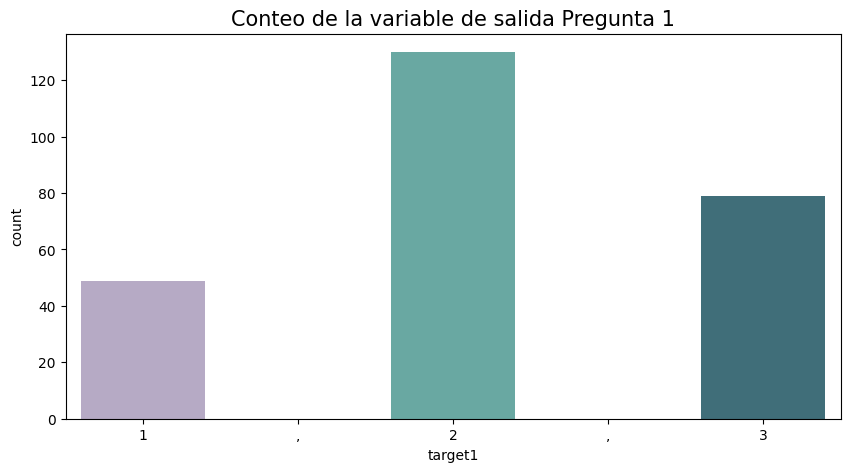

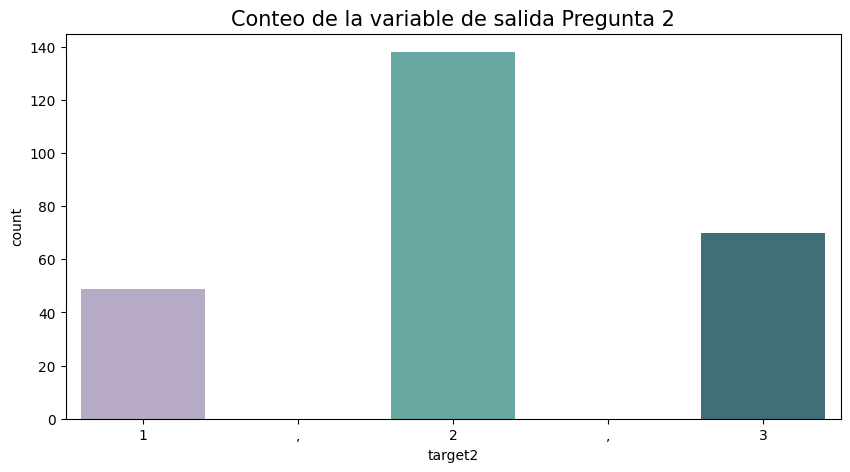

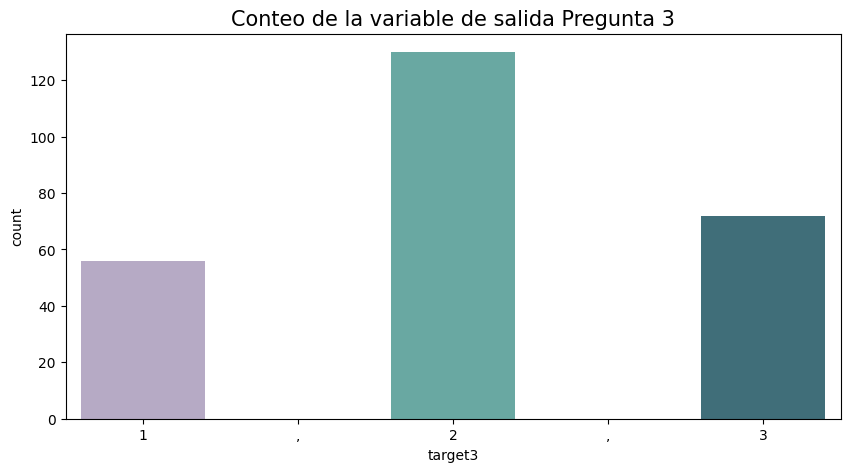

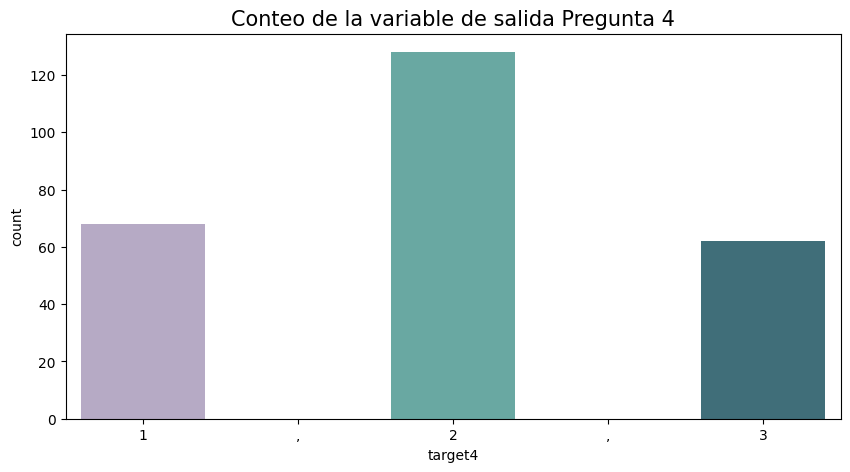

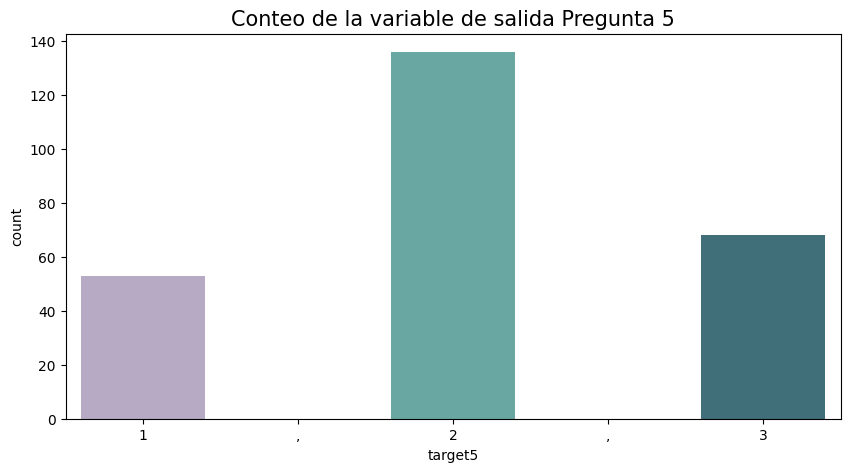

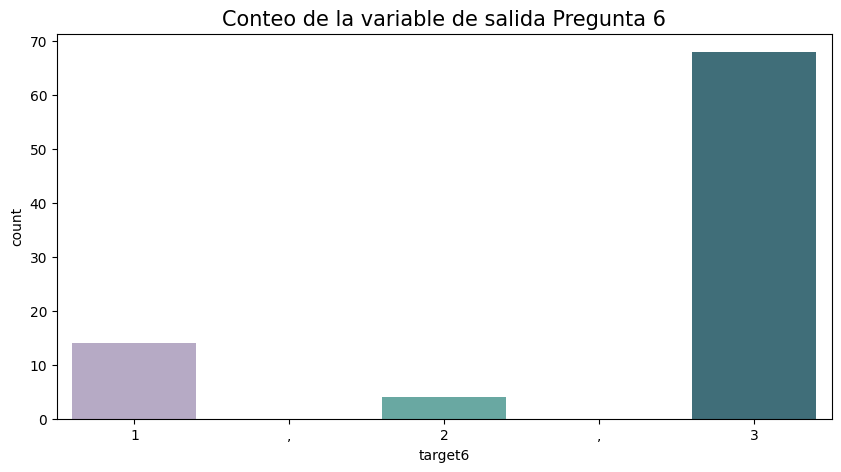

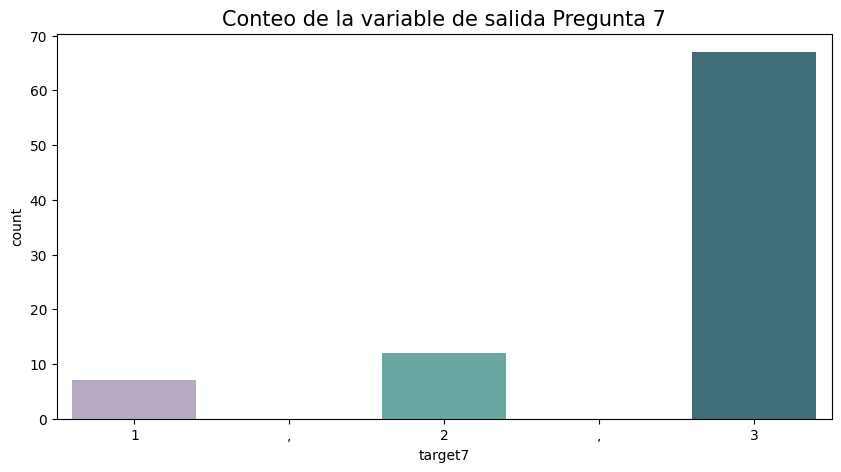

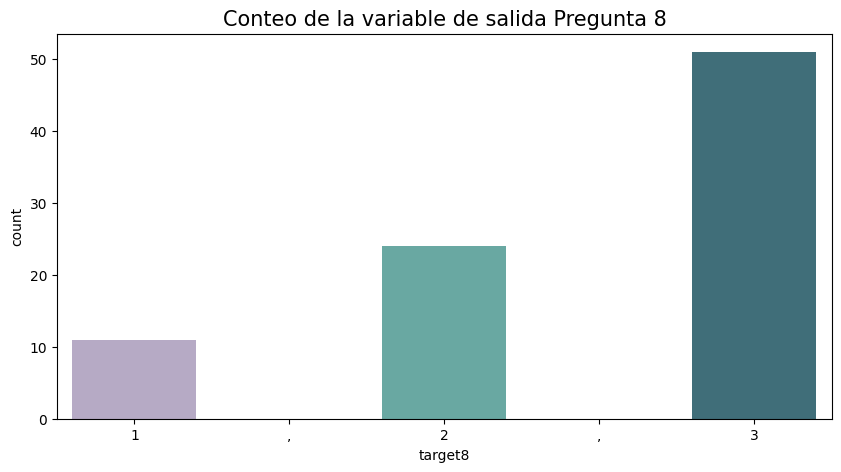

In [ ]:


#Graficar las variable target para observar si hay desbalance de datos y tomar medidas a la hora de entrenar el modelo
for key, pregunta in preguntas.items():
  plt.figure(figsize=(10,5))
  sns.countplot(x = pregunta.iloc[:, -1] ,label= 'Count', data = pregunta, order='1,2,3', palette=palette)
  plt.title('Conteo de la variable de salida {pregunta}'.format(pregunta=key), fontsize = 15)
  plt.show()

### Funciones para limpiar el texto

In [ ]:
# Librería para ignorar warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # "error", "ignore", "always", "default", "module" or "once"

In [ ]:
# Descargamos la lista de stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Importamos librerías para tokenizar, normalizar y eliminar stopwords al texto

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from string import punctuation

In [ ]:
# Funciones

spanish_stopwords = stopwords.words('spanish') #Preparamos la lista de stopwords para español
stemmer = SnowballStemmer('spanish')  #Preparamos la lista para extraer la raíz de las palabras en español
non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))

# Función para quitar los acentos del texto
def normalize(s):
    s = s.lower() #Pasa a minúsculas
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper()) #quita los acentos

    return s

# Función para stematizar el texto, las palabras se guardan en una lista
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

# Función para tokenizar el texto, eliminamos signos de puntuación
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

### Funciones para vectorizar el texto

In [ ]:
# Librerías para vectorizar
from sklearn.feature_extraction.text import CountVectorizer #Bag_of_words
from sklearn.feature_extraction.text import TfidfVectorizer #Asigna un peso respecto a lo relevante que es una palabra en un documento
from sklearn.feature_extraction.text import HashingVectorizer #Convierte una colección de documentos de texto en una matriz de ocurrencias de tokens

# Funciones para vectorizar
vectorizer_bag_of_words = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

vectorizer_tfidf = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords,
                token_pattern=r'(?u)\b\w\w+__\([\w\s]*\)')

vectorizer_hash = HashingVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords,
                alternate_sign=False)

# Se guardan en un diccionario
vectorizadores = {'bow': vectorizer_bag_of_words,
                  'tfidf': vectorizer_tfidf,
                  'hash': vectorizer_hash}

### Instanciamos los modelos de aprendizaje para NLP

In [ ]:
# Importamos librería para pipeline

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Instanciamos cada algoritmo

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, class_weight='balanced')
svm_lin = LinearSVC(class_weight='balanced')
svm_poly = SVC(kernel='poly', class_weight='balanced')
svm_rbf = SVC(kernel='rbf', class_weight='balanced')
svm_sig = SVC(kernel='sigmoid', class_weight='balanced')
rf_20 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=20, random_state=0, class_weight='balanced')
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0, class_weight='balanced')

# Se guardan en un diccionario
clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM polinomico': svm_poly,
                  'SVM Kernel rbf': svm_rbf,
                  'SVM Kernel Sigmoid': svm_sig,
                  'Random Forest d_20': rf_20,
                  'Random Forest d_50': rf_50}

### Función para evaluar los modelos con las siguientes métricas (Accuracy, Recall, Precision, F1)

In [ ]:
# Librería para medir las métricas de evaluación
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# Librería para hacer la división de datos
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

#Preparamos el mapa de color personalizado para las gráficas de confusión
cmap = ListedColormap(["#5fb2aa", "#33d9bb", "#b6a5ca", "#367482", "#4b2685", "#70ad47"])

''' La función requiere de 6 variables, las cuales describo a continuación:

  -vect = Llama al vectorizador
  -name_v = Nombre del vectorizador
  -algotitm = Llama al algoritmo
  -name = Nombre del algoritmo
  -pregunta = Llama al dataframe de la pregunta que se desea entrenar
  -df = Llama al dataframe nuevo donde se guardarán los resultados obtenidos de las métricas

'''

def pipeline(vect, name_v, algoritm, name, pregunta, df):
  #instanciar el modelo
  pipe=Pipeline([
      ('vect', vect),
      ('cls', algoritm)
  ])

  #Sepando las variables
  Y = pregunta.iloc[:, -1]
  X = pregunta.iloc[:, 0]

  #Preparación de la data para datos de entramiento - datos de prueba
  X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.80, random_state = 21, stratify=Y)

  #Se eliminan los acentos del texto
  X_train = X_train.apply(lambda fila: normalize(fila))

  #Entrenar el modelo
  pipe.fit(X_train, y_train)

  #Evaluacion del modelo
  y_pred_test = pipe.predict(X_test)
  accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_test)
  precision = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
  recall = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
  f1 = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')

  #Matriz de confusion
  print(f'Confusion Matrix for Model "{name}" with method "{name_v}" \n')
  c_m = confusion_matrix(y_test, y_pred_test)
  sns.heatmap(c_m, cmap=cmap, annot=True,
              xticklabels=[1,2,3], yticklabels=[1,2,3])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  print('---------------------------------------------------------------------- \n')

  # Agregar los resultados al DataFrame
  df.loc[len(df)]={'Model': name, 'Vect': name_v, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

In [ ]:
# Crear un DataFrame para almacenar los resultados
Resultados= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

**Se corre la función para un sólo parámetro como muestra**

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



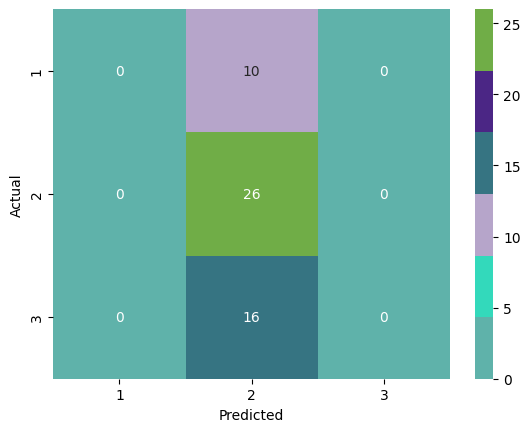

---------------------------------------------------------------------- 



In [ ]:
#Probando la función con un dato

df_prueba= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision', 'Recall', 'F1-score']) #Se crea el dataframe donde se almacenarán los resultados

pipeline(vectorizadores['hash'], 'hash',clasificadores['Bernoulli NB'], 'Bernoulli NB', df1, df_prueba)

In [ ]:
#Imprimiendo el dataframe para comprobar los resultados
df_prueba

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Bernoulli NB,hash,0.5,0.25,0.5,0.333333


### SELECCIÓN DE MODELO PARA PREGUNTA 1

Confusion Matrix for Model "Multinomial NB" with method "bow" 



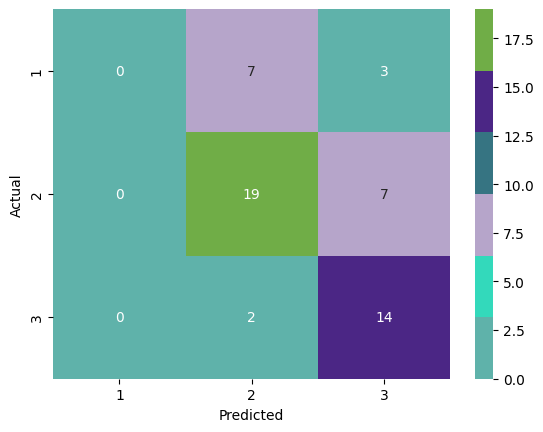

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



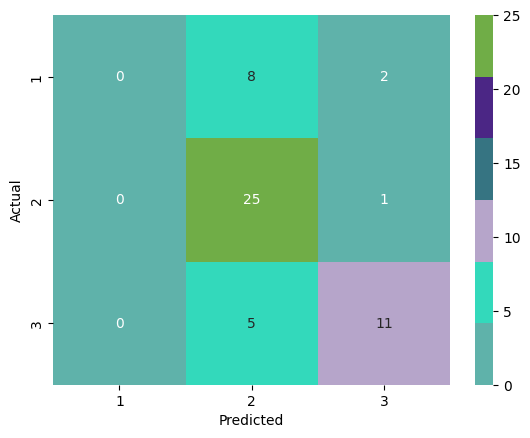

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



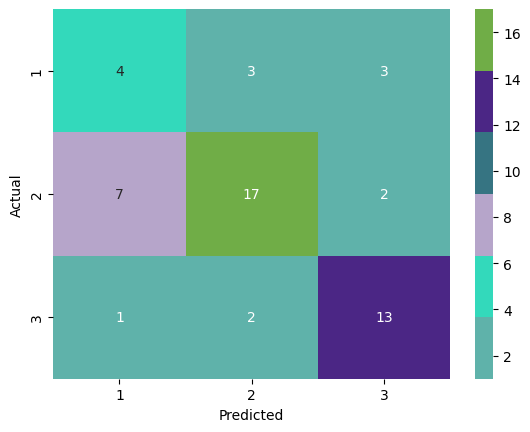

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



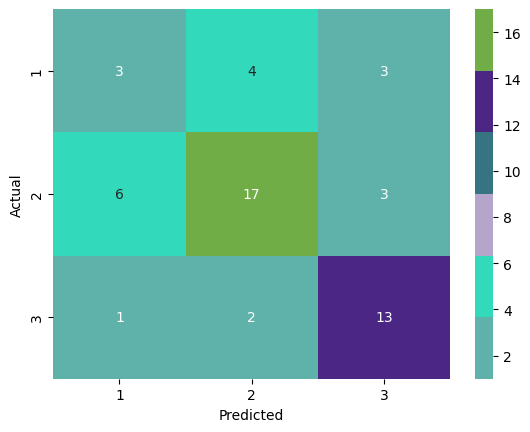

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



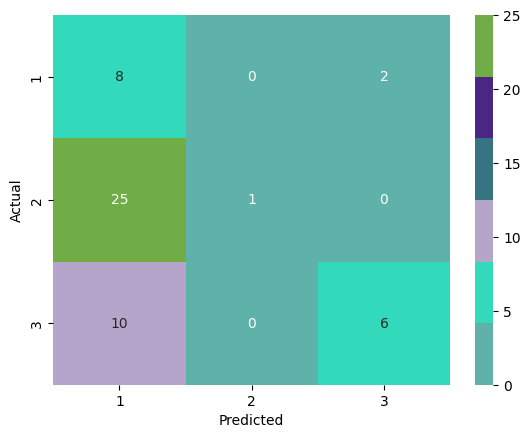

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



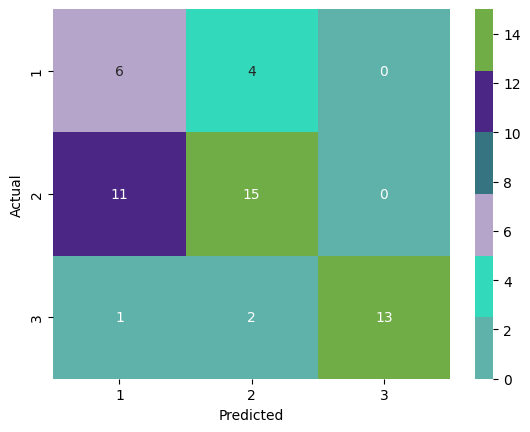

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



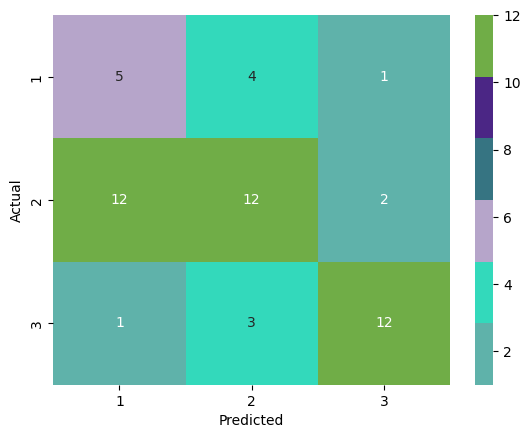

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



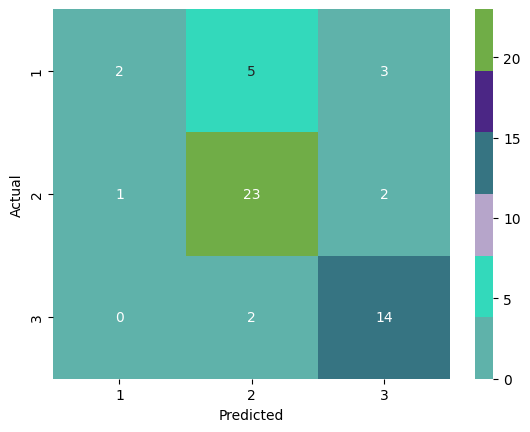

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



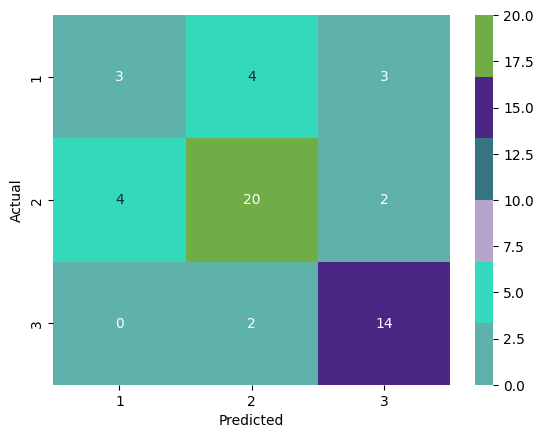

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



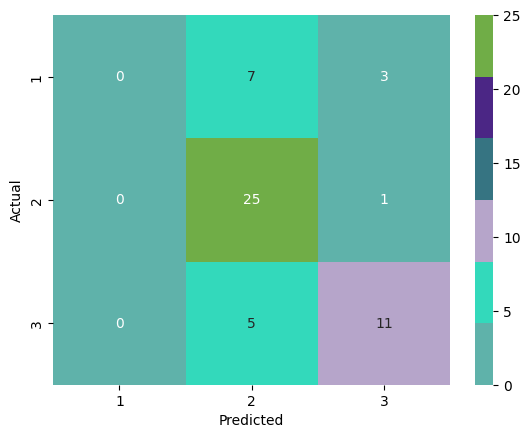

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



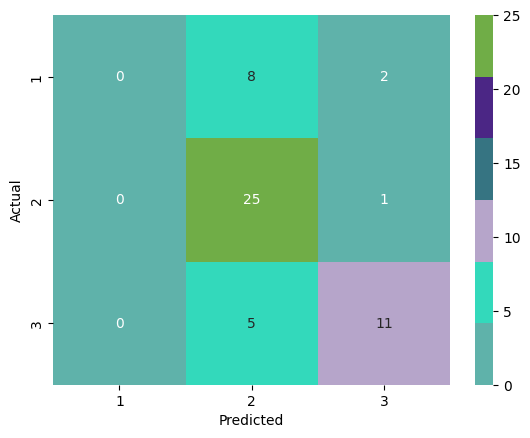

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



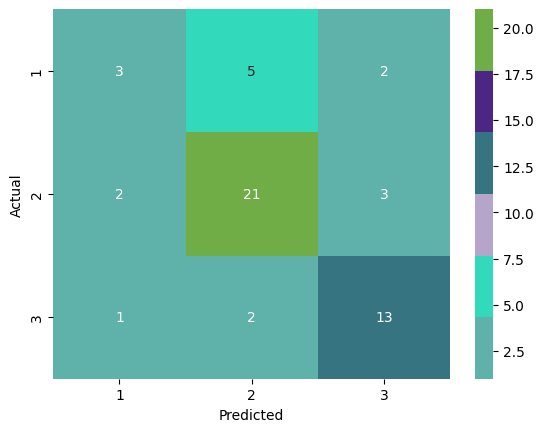

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



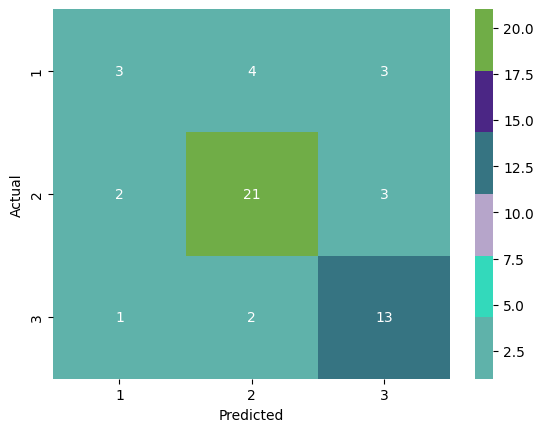

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



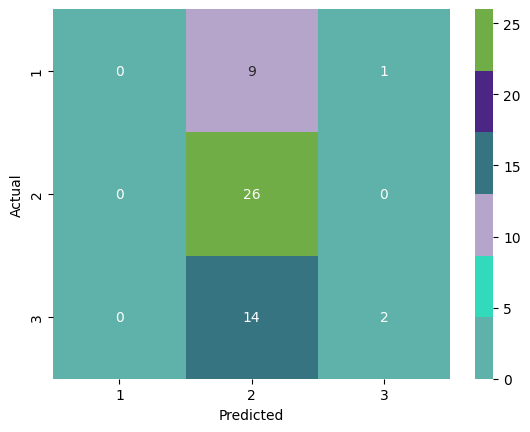

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



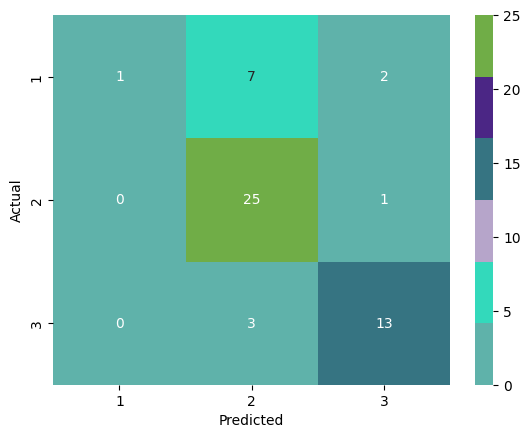

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



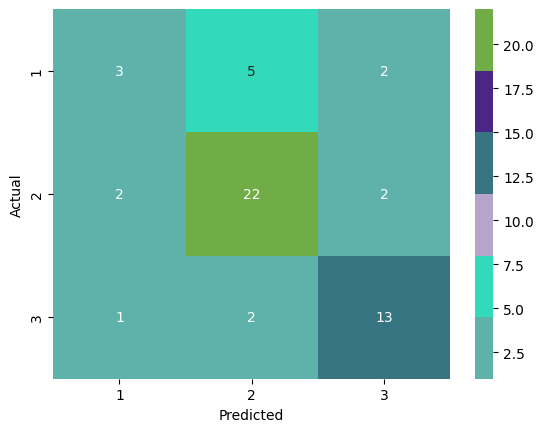

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



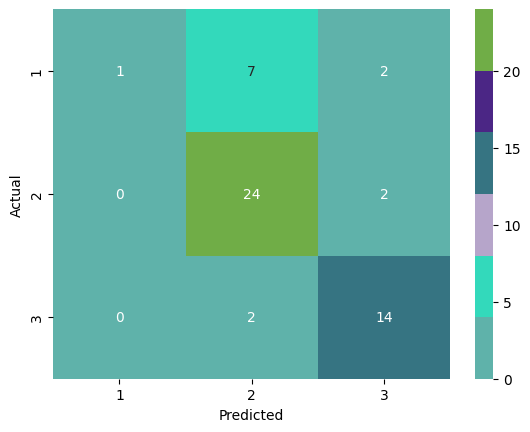

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



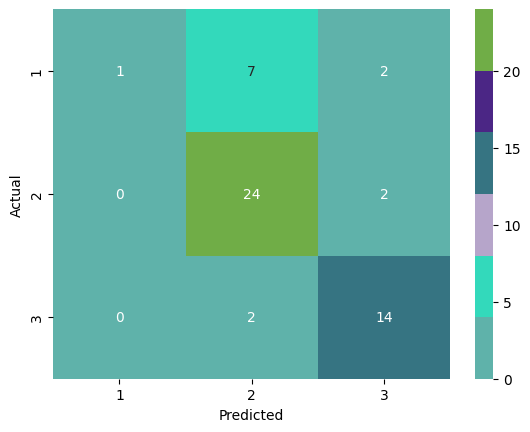

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



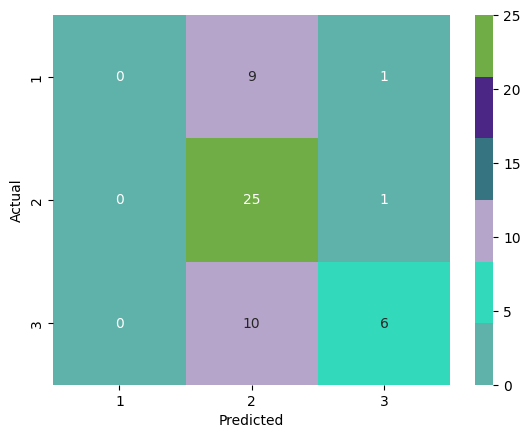

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



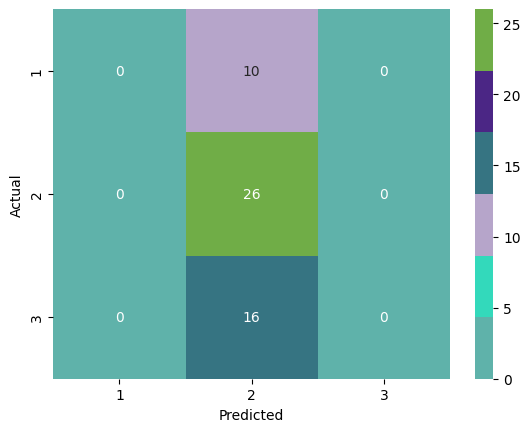

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



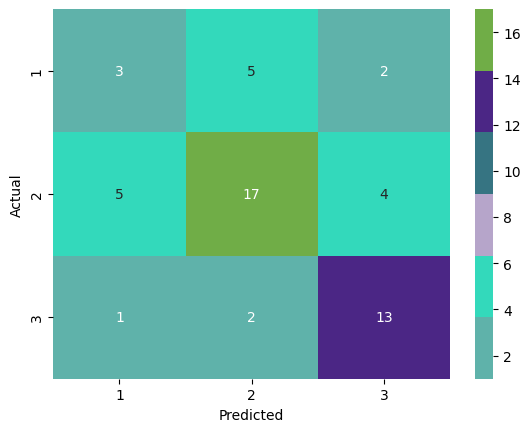

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



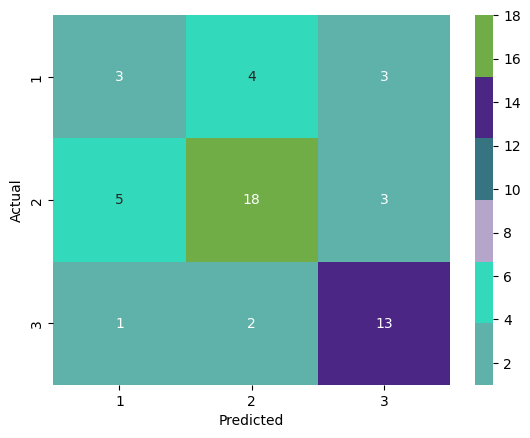

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



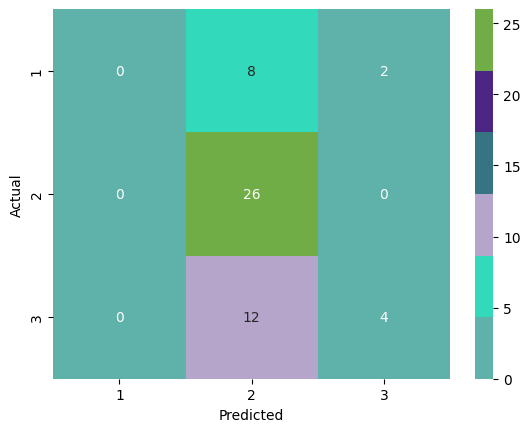

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



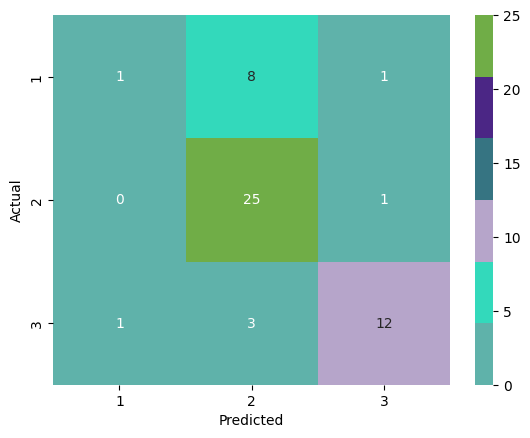

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



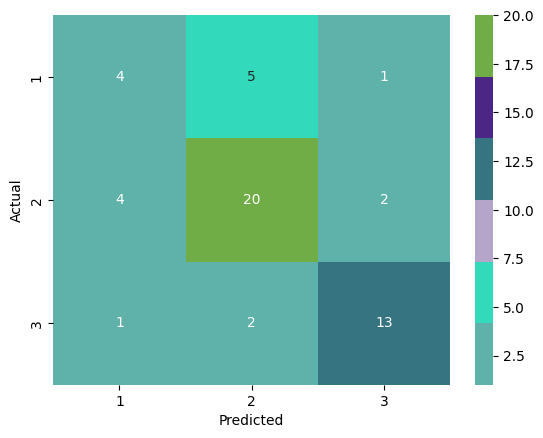

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



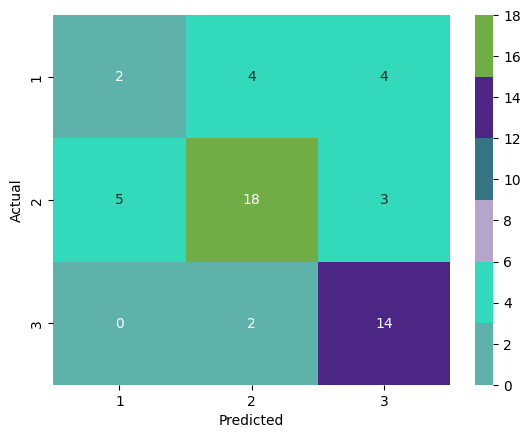

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



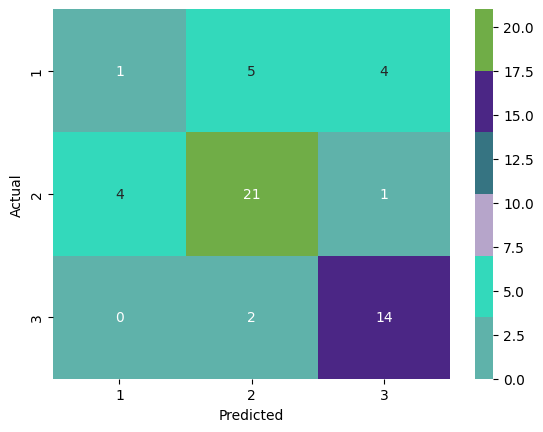

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df1, df=Resultados)

In [ ]:
Resultados

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.634615,0.518773,0.634615,0.567236
1,Bernoulli NB,bow,0.692308,0.570706,0.692308,0.616266
2,Regresion Logistica,bow,0.653846,0.672688,0.653846,0.659391
3,SVM lineal,bow,0.634615,0.637784,0.634615,0.633203
4,SVM polinomico,bow,0.288462,0.766547,0.288462,0.248938
5,SVM Kernel rbf,bow,0.653846,0.728938,0.653846,0.677429
6,SVM Kernel Sigmoid,bow,0.557692,0.615362,0.557692,0.573561
7,Random Forest d_20,bow,0.750000,0.738259,0.750000,0.716040
8,Random Forest d_50,bow,0.711538,0.693754,0.711538,0.698643
9,Multinomial NB,tfidf,0.692308,0.563479,0.692308,0.615188


OBSERVACIONES:
Analizando los resultados tanto el modelo *Random Forest_d20* cómo el *Random Forest_d20* vectorizado ambos con TF-IDF son los que tuvieron mejor rendimiento de manera general en las tres variables de salida, tienen un F1: 0.7952 y precisión: 0.0.6951

Si bien estos modelos tuvieron un mejor score en F1 al vectorizarlos con Bag_of_words, la precisión no es tan alta cómo en el caso anterior. Pero también se podría considerar para futuras investigaciones


### SELECCIÓN DE MODELO PARA PREGUNTA 2

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_2= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



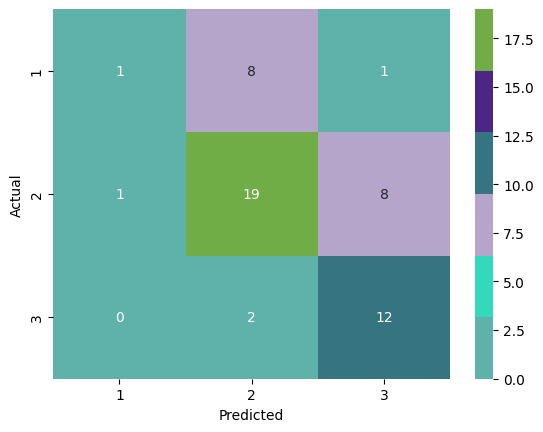

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



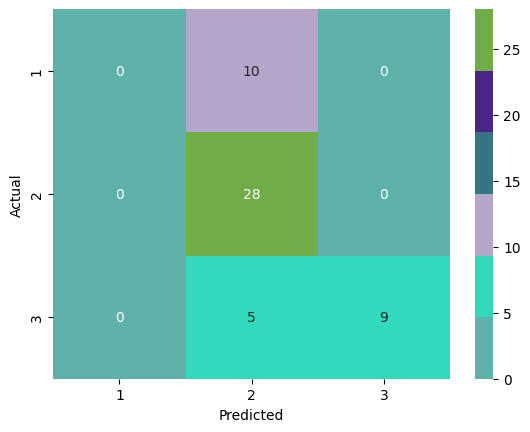

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



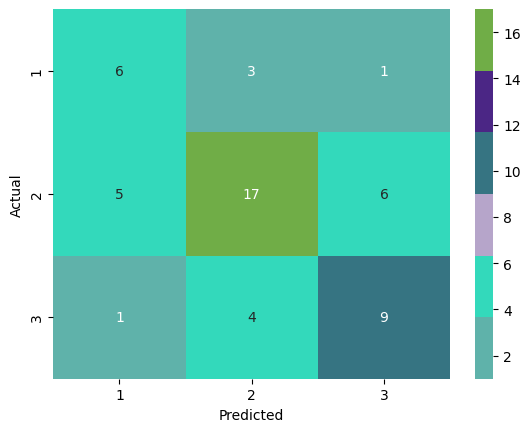

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



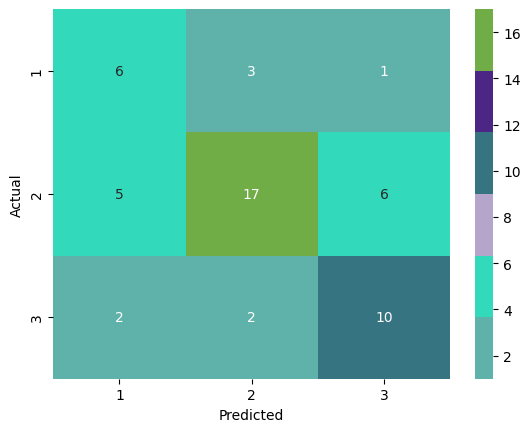

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



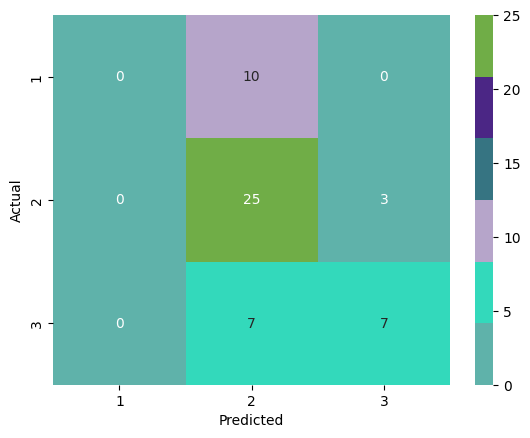

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



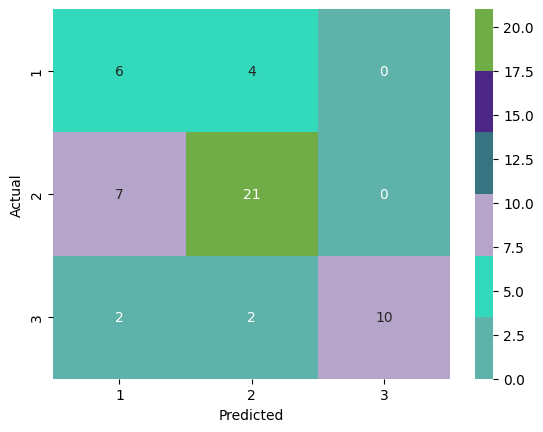

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



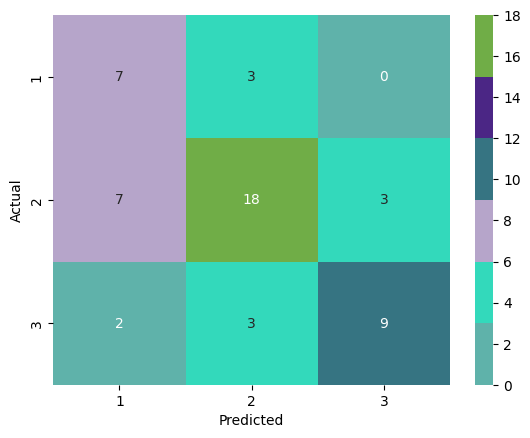

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



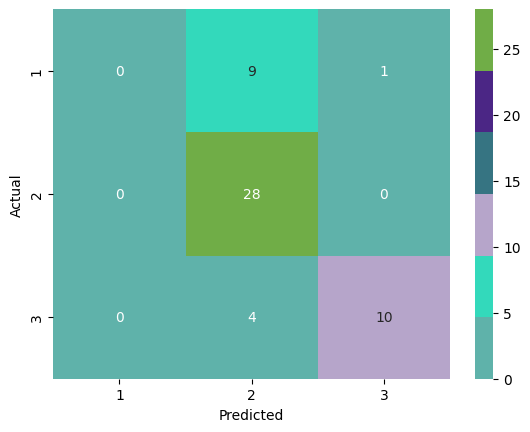

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



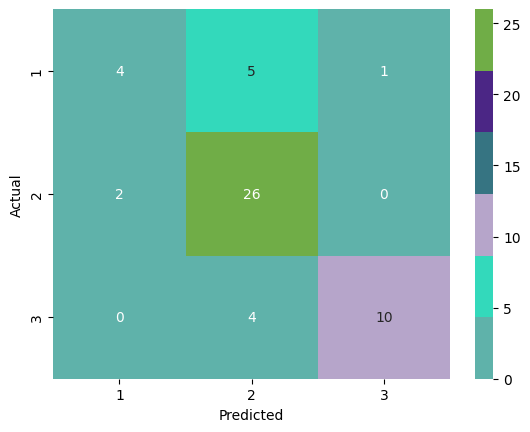

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



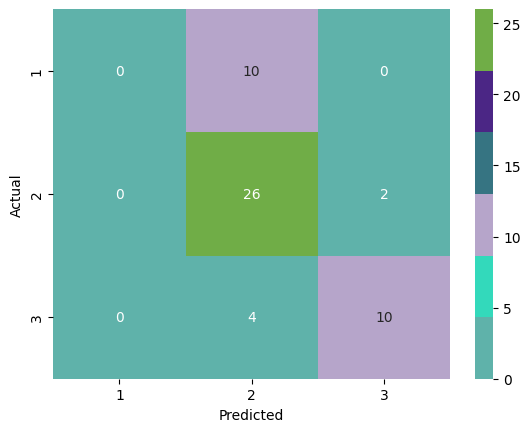

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



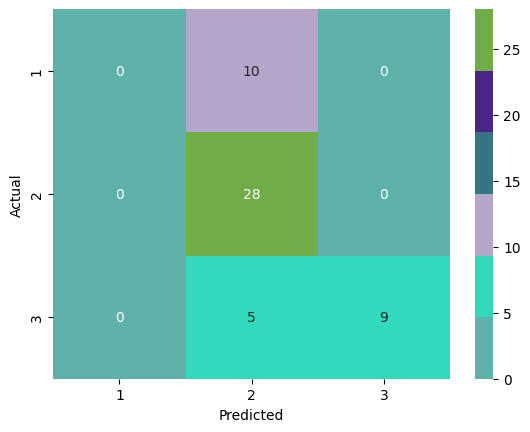

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



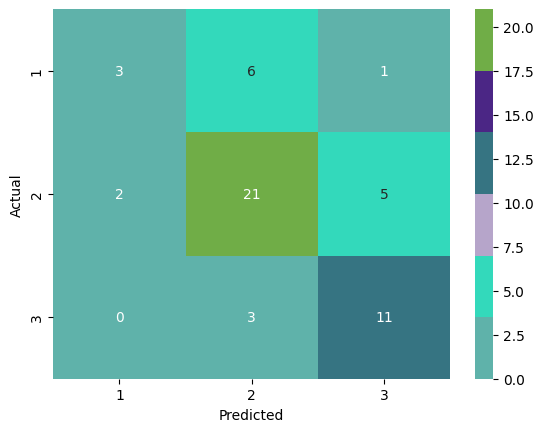

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



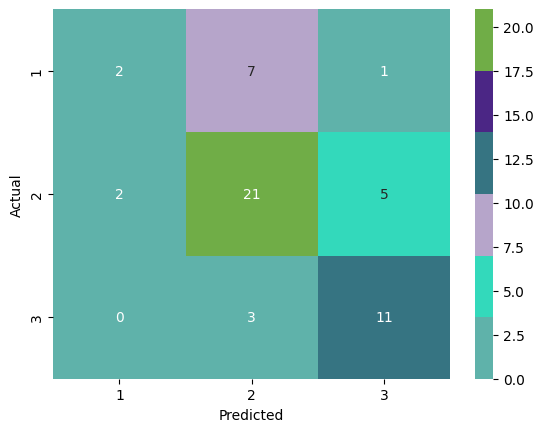

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



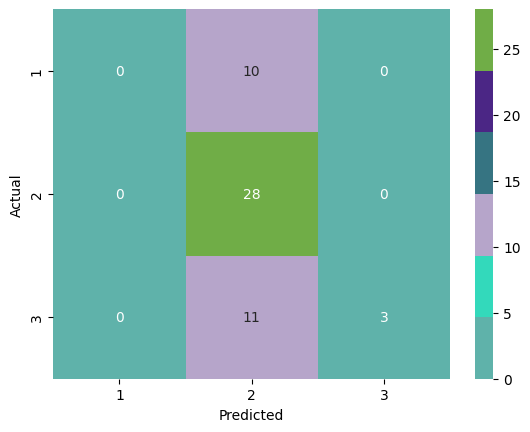

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



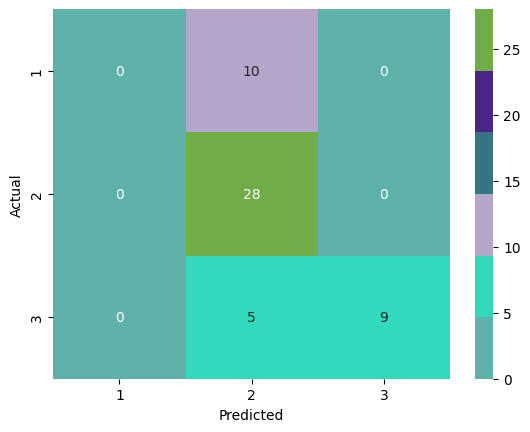

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



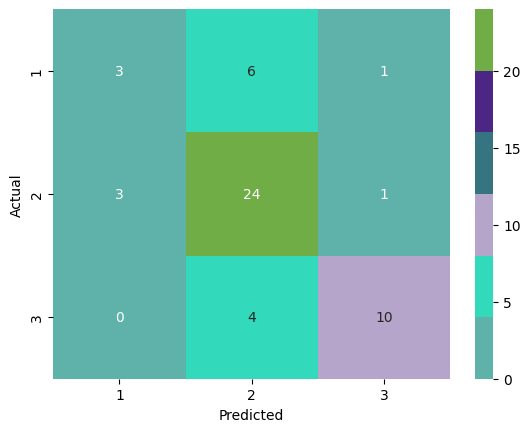

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



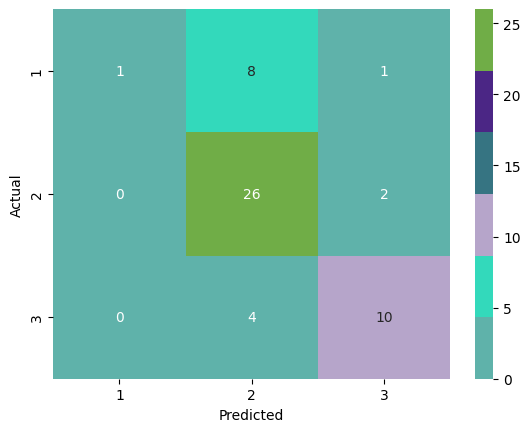

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



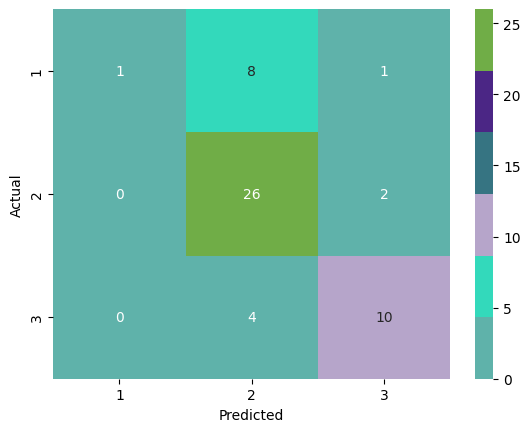

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



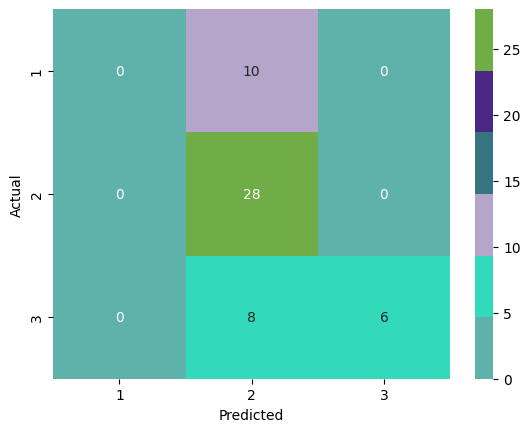

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



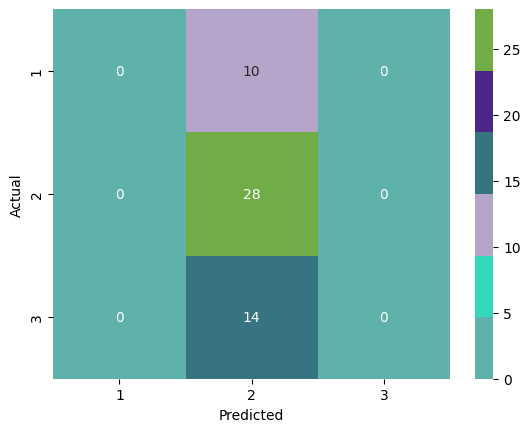

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



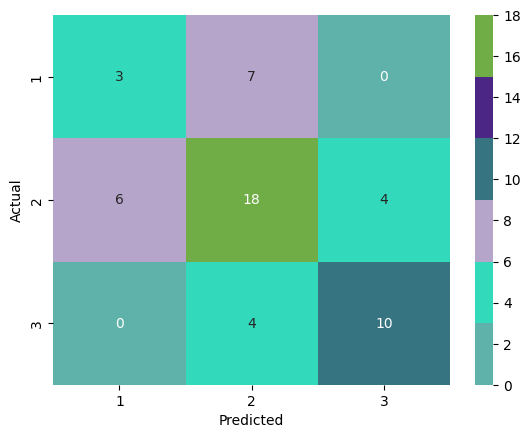

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



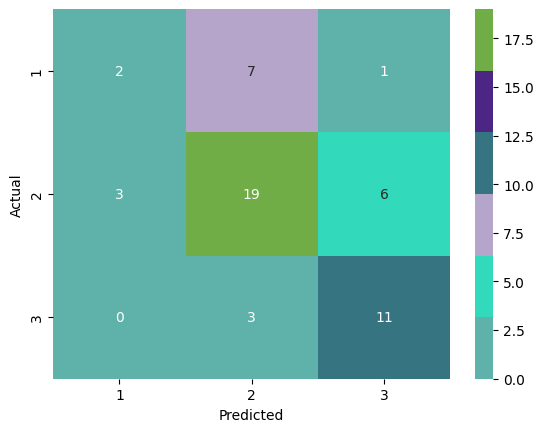

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



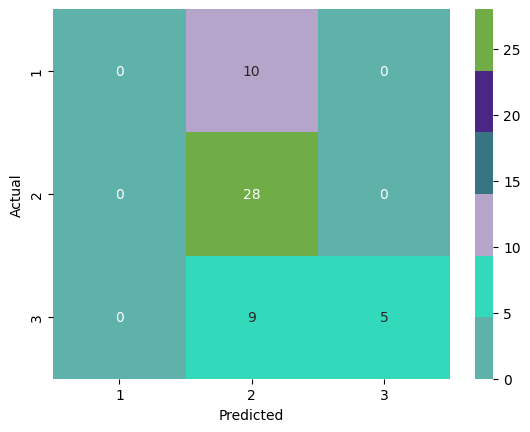

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



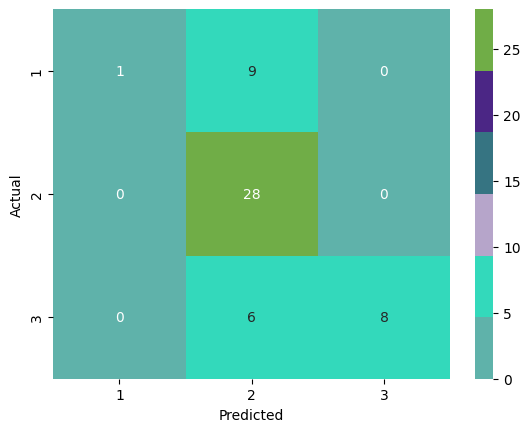

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



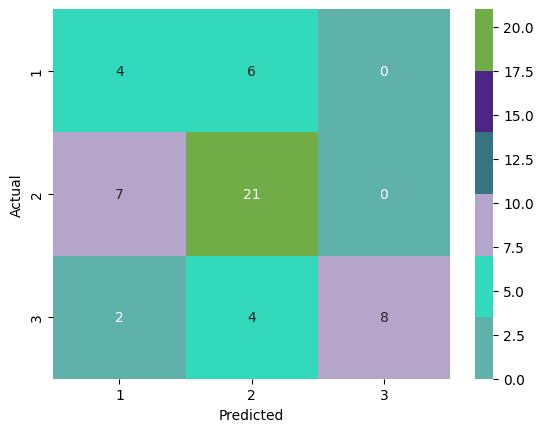

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



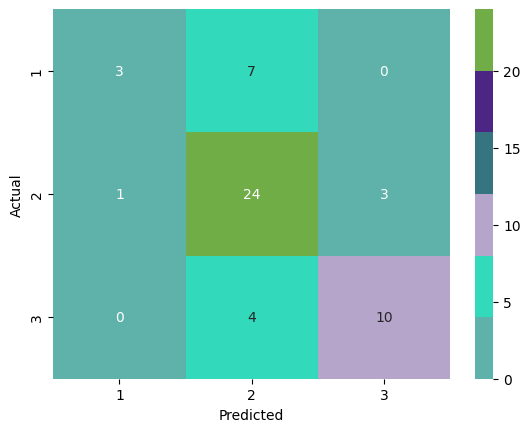

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



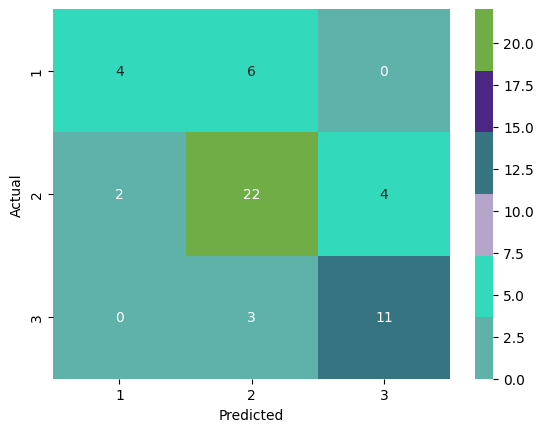

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df2, df=Resultados_2)

In [ ]:
Resultados_2

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.615385,0.602785,0.615385,0.575641
1,Bernoulli NB,bow,0.711538,0.619857,0.711538,0.635404
2,Regresion Logistica,bow,0.615385,0.629006,0.615385,0.618505
3,SVM lineal,bow,0.634615,0.663212,0.634615,0.640186
4,SVM polinomico,bow,0.615385,0.508974,0.615385,0.541667
5,SVM Kernel rbf,bow,0.711538,0.764957,0.711538,0.727855
6,SVM Kernel Sigmoid,bow,0.653846,0.689904,0.653846,0.662722
7,Random Forest d_20,bow,0.730769,0.612485,0.730769,0.652397
8,Random Forest d_50,bow,0.769231,0.772960,0.769231,0.755983
9,Multinomial NB,tfidf,0.692308,0.574359,0.692308,0.618865


OBSERVACIONES:
Analizando los resultados el modelo *Random Forest_d50* vectorizado con Bag_of_Words tuvo mejor rendimiento de manera general en las tres variables de salida, tiene un F1: 0.756 y precisión: 0.773



### SELECCIÓN DE MODELO PARA PREGUNTA 3

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_3= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



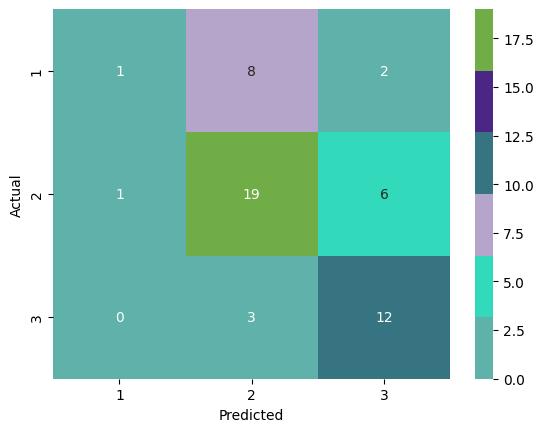

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



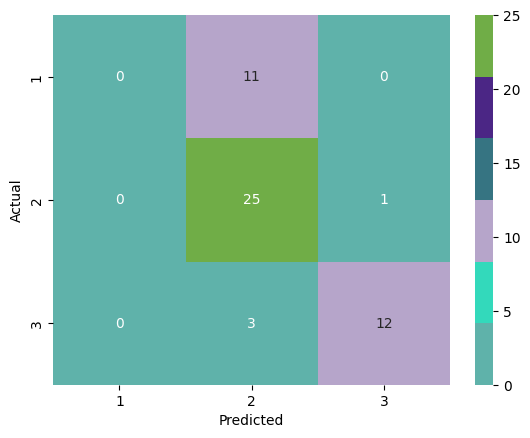

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



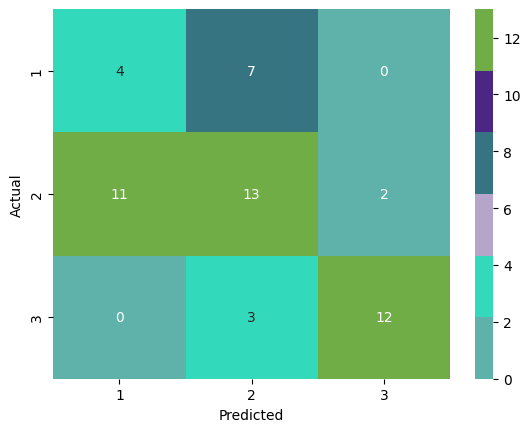

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



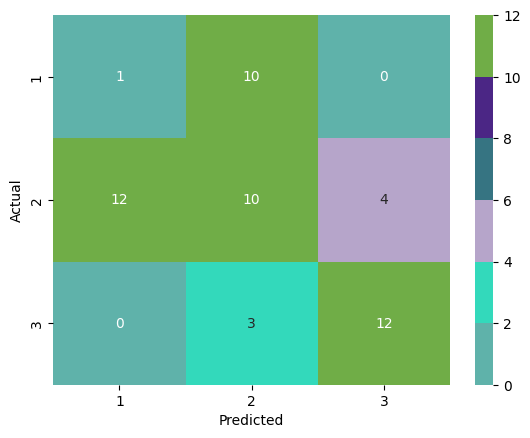

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



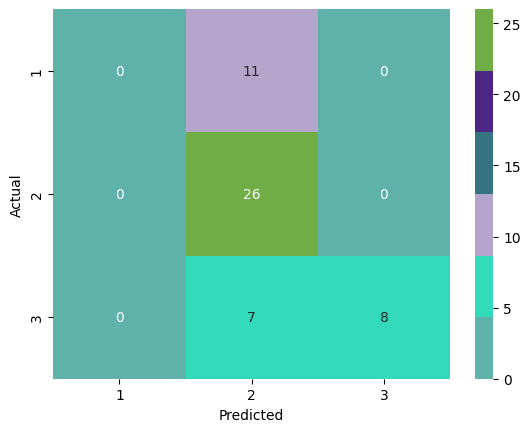

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



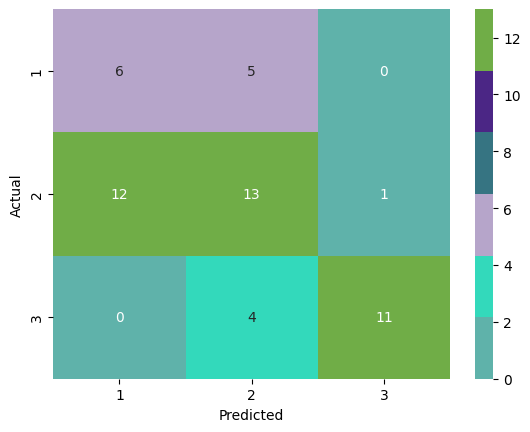

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



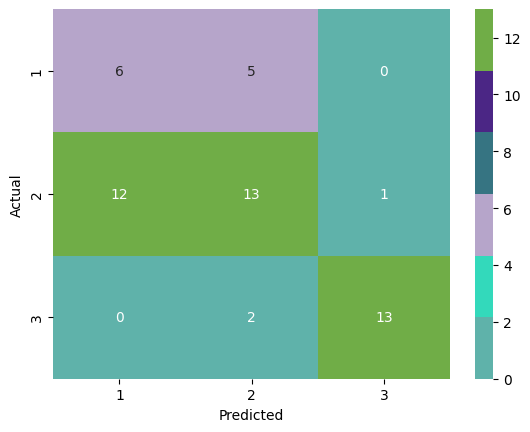

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



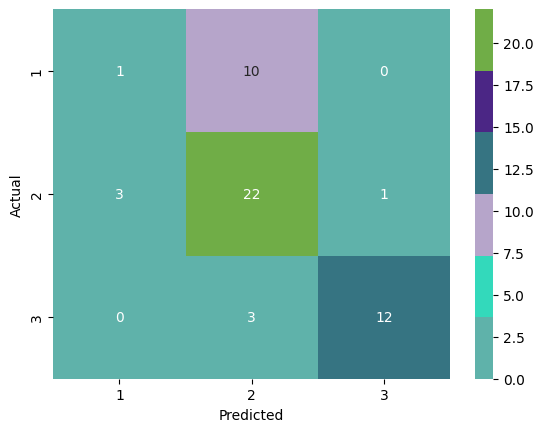

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



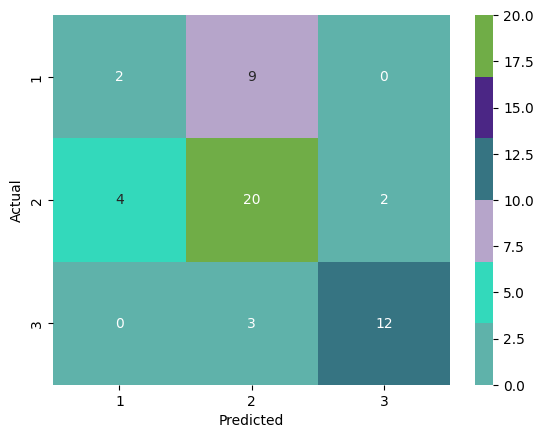

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



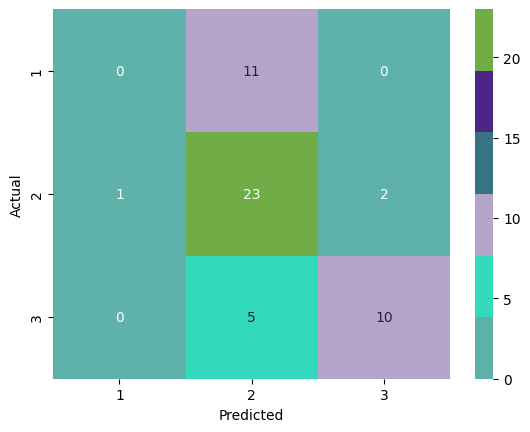

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



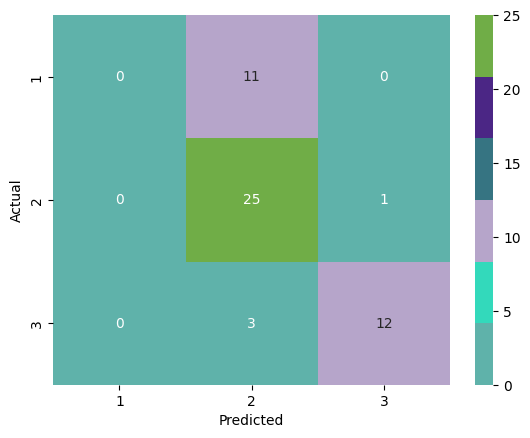

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



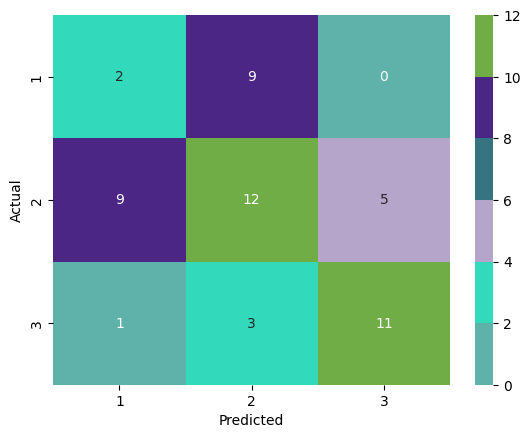

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



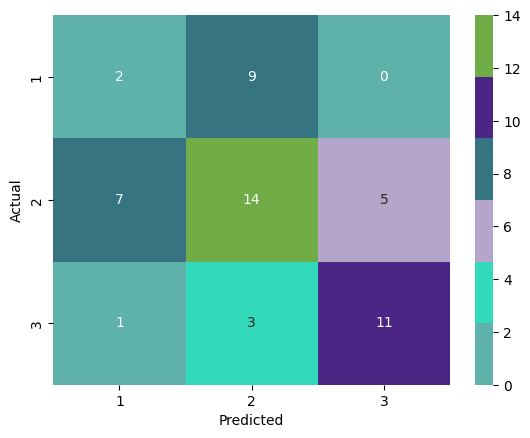

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



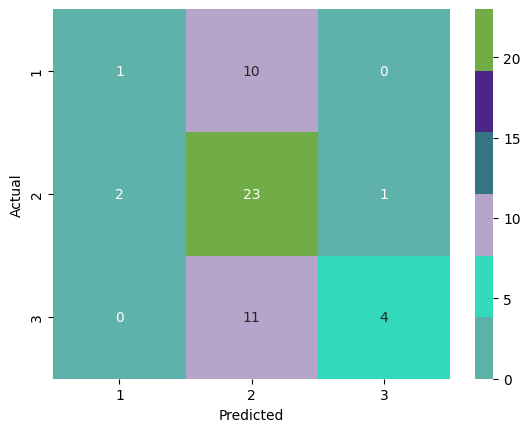

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



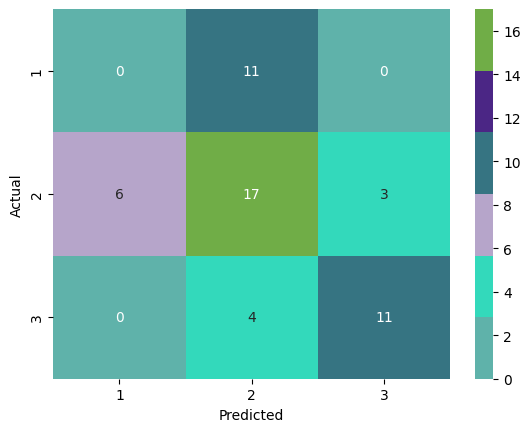

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



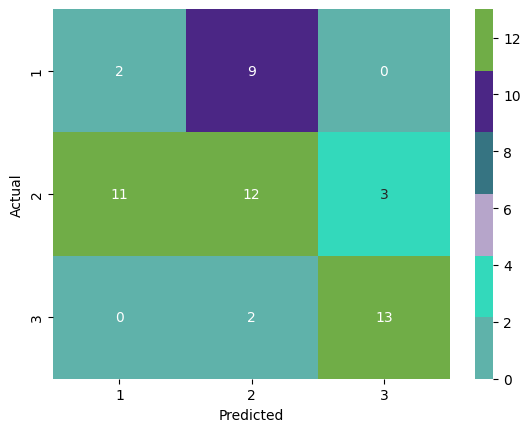

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



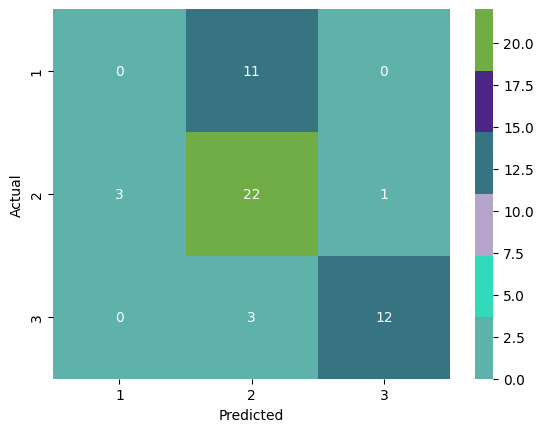

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



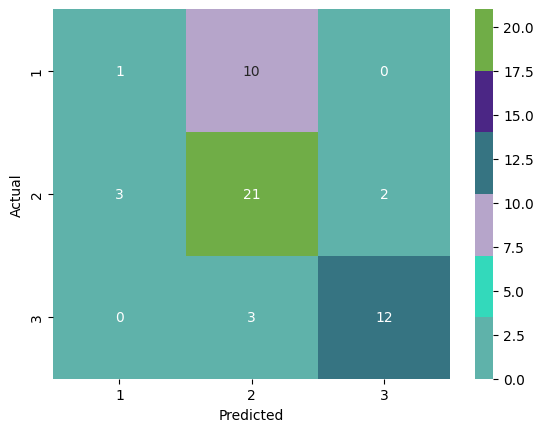

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



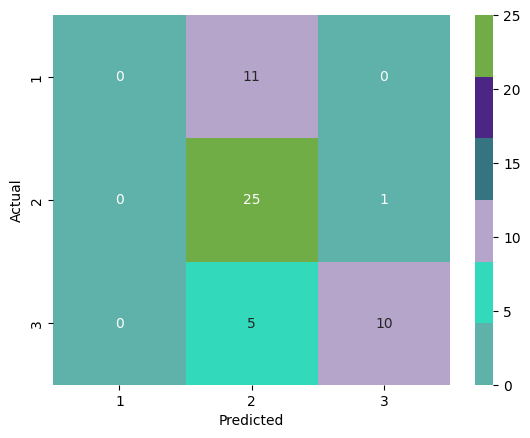

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



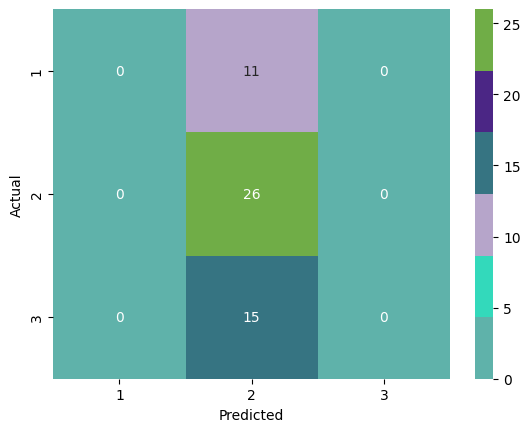

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



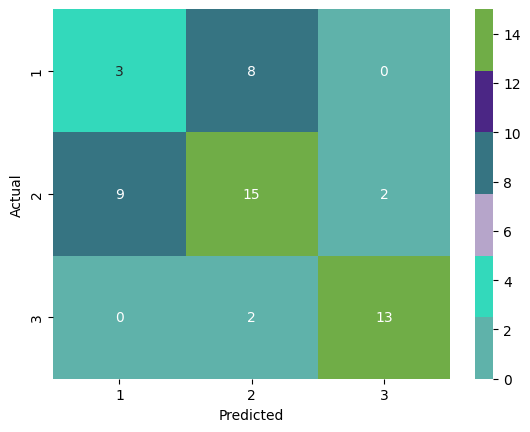

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



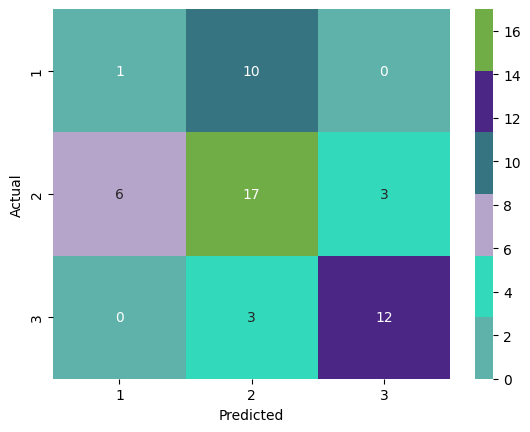

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



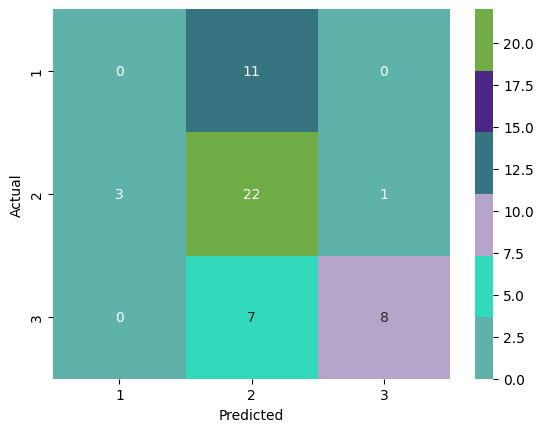

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



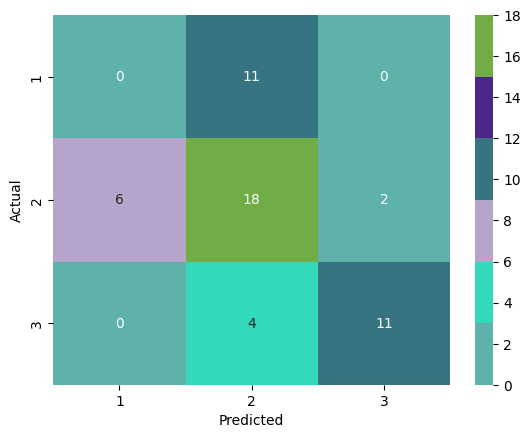

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



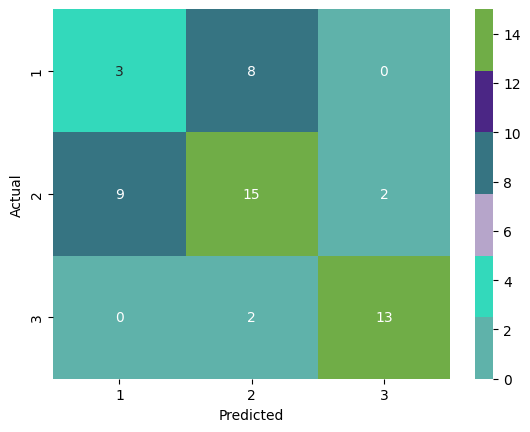

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



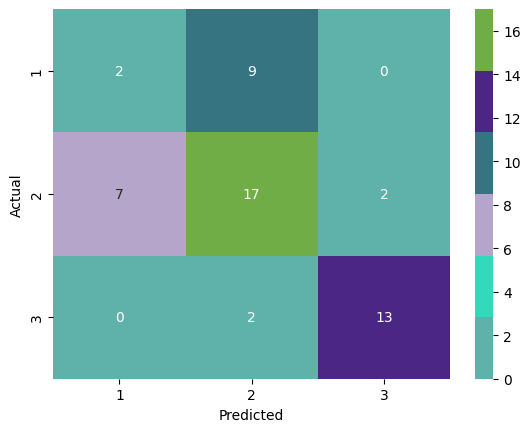

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



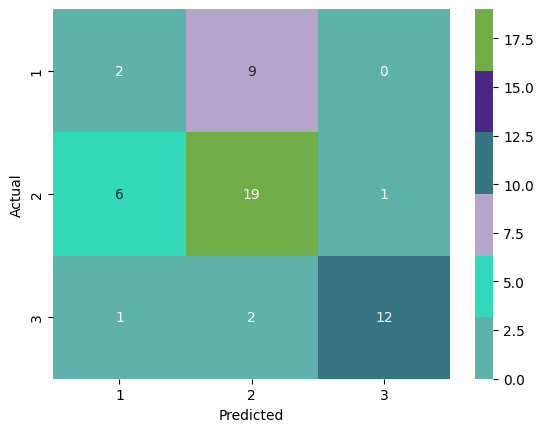

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df3, df=Resultados_3)

In [ ]:
Resultados_3

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.615385,0.595513,0.615385,0.569632
1,Bernoulli NB,bow,0.711538,0.586785,0.711538,0.631868
2,Regresion Logistica,bow,0.557692,0.586272,0.557692,0.569122
3,SVM lineal,bow,0.442308,0.450010,0.442308,0.445035
4,SVM polinomico,bow,0.653846,0.583916,0.653846,0.572097
5,SVM Kernel rbf,bow,0.576923,0.630390,0.576923,0.593409
6,SVM Kernel Sigmoid,bow,0.615385,0.663370,0.615385,0.628763
7,Random Forest d_20,bow,0.673077,0.633443,0.673077,0.636114
8,Random Forest d_50,bow,0.653846,0.630266,0.653846,0.633328
9,Multinomial NB,tfidf,0.634615,0.535256,0.634615,0.567521


OBSERVACIONES:
Analizando los resultados el modelo *Random Forest_d20* vectorizado con Bag_of_Words tuvo mejor rendimiento de manera general en las tres variables de salida, tiene un F1: 0.636 y precisión: 0.633


### SELECCIÓN DE MODELO PARA PREGUNTA 4

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_4= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



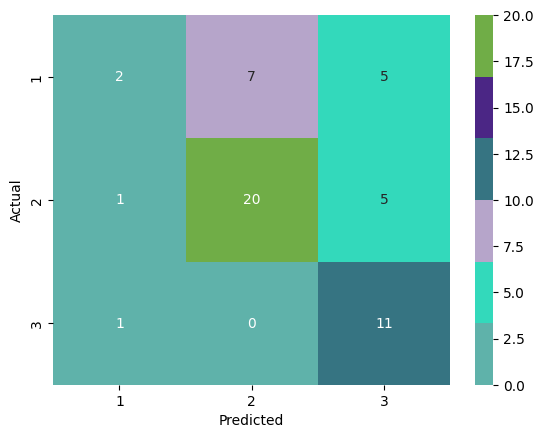

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



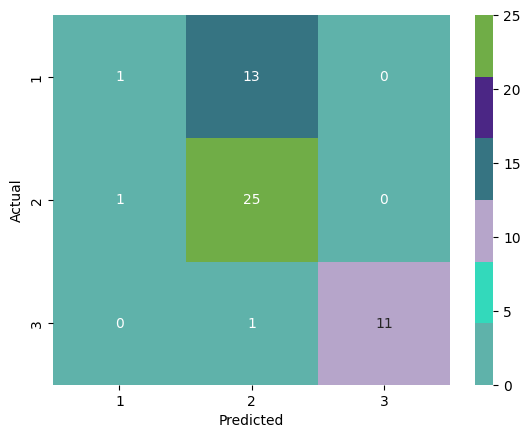

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



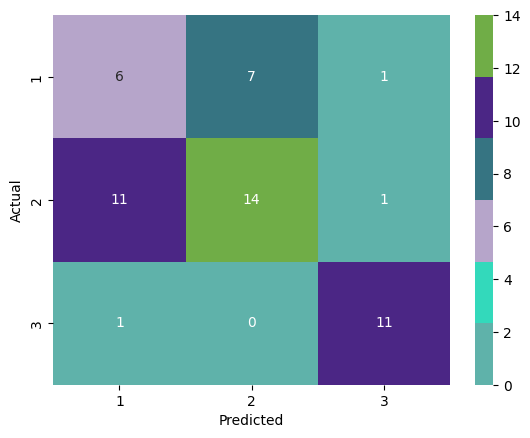

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



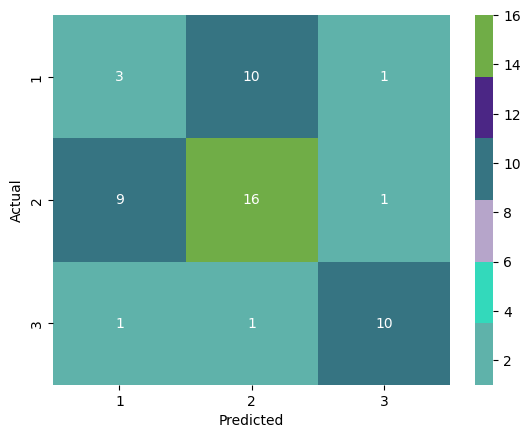

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



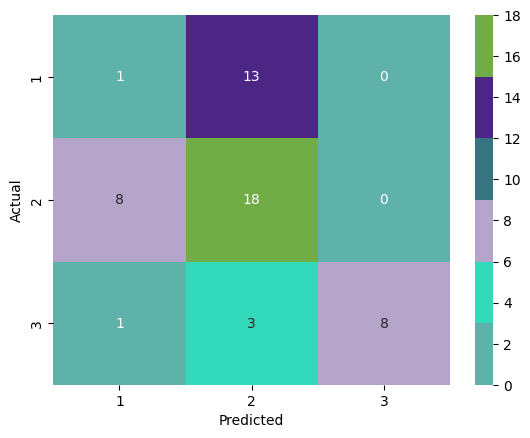

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



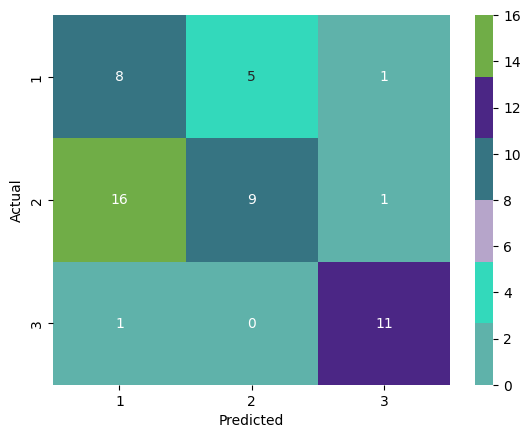

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



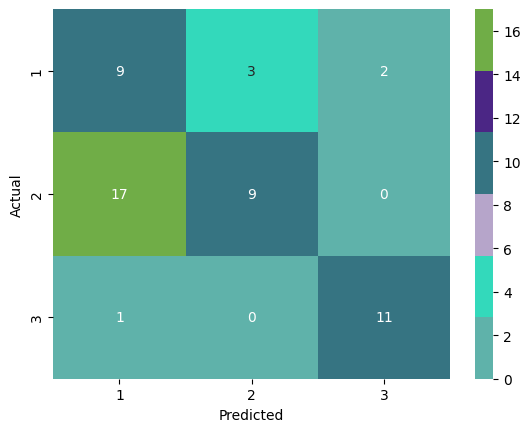

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



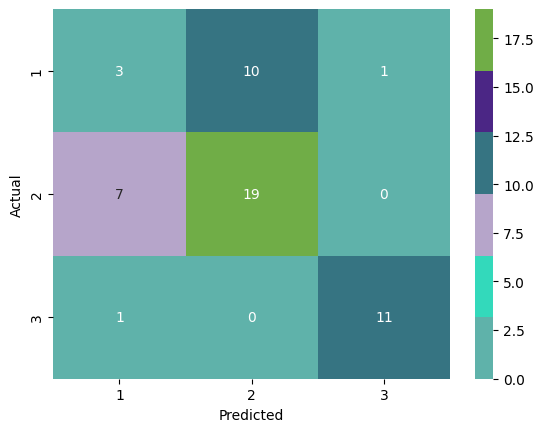

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



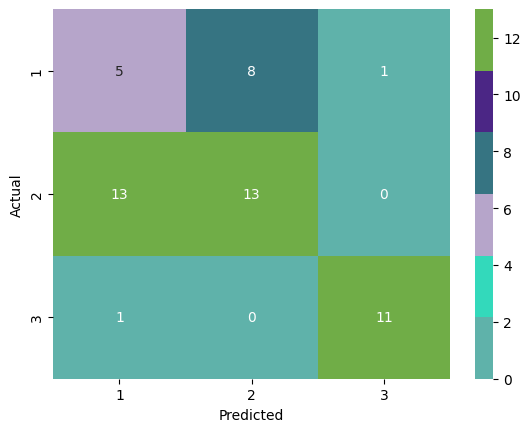

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



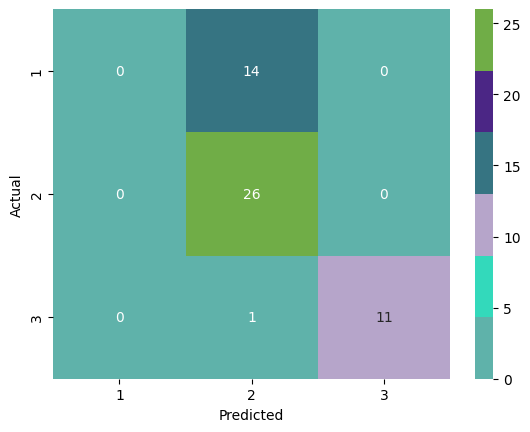

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



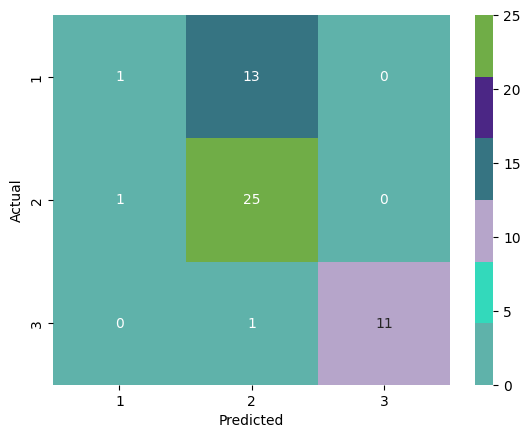

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



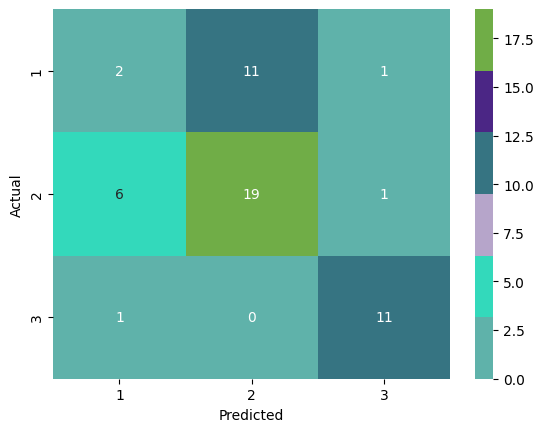

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



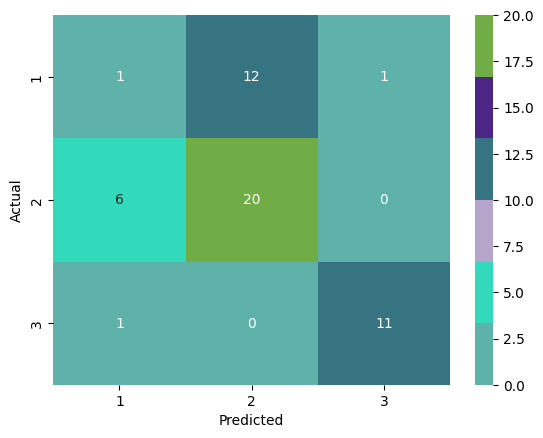

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



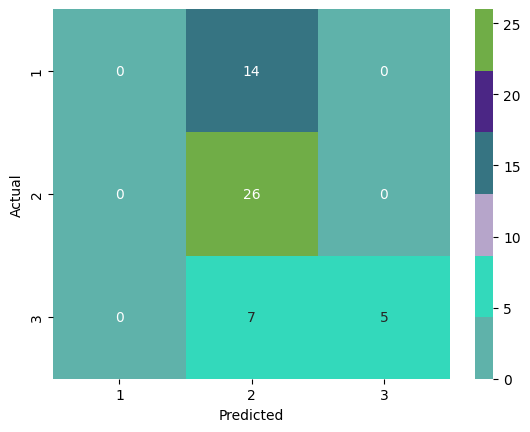

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



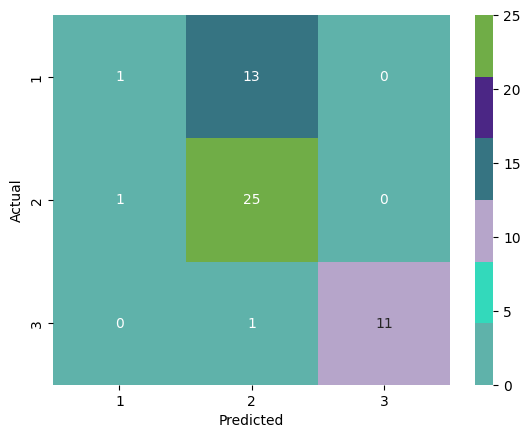

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



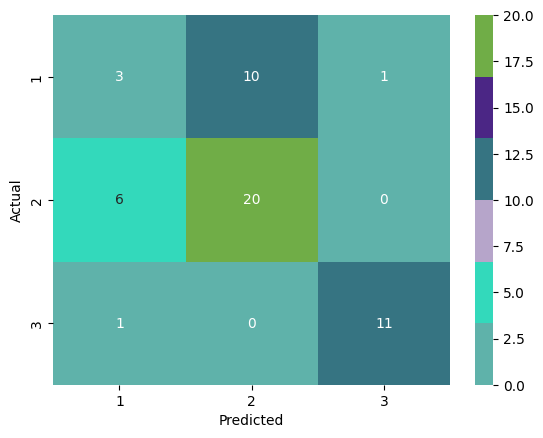

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



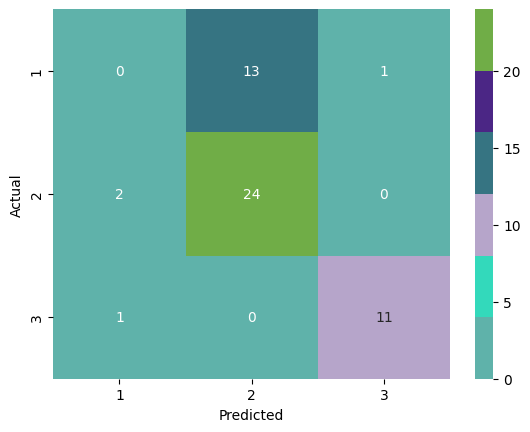

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



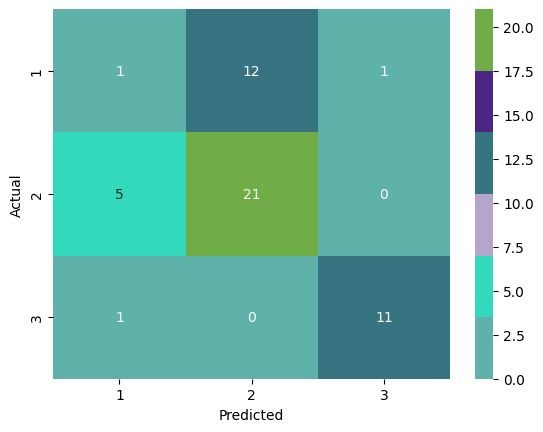

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



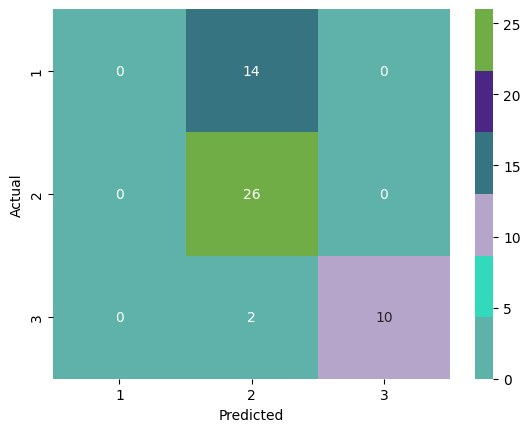

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



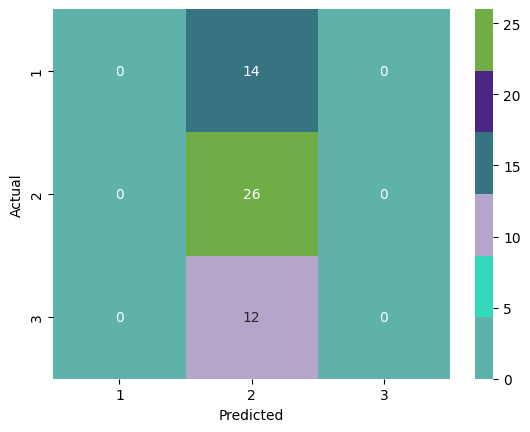

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



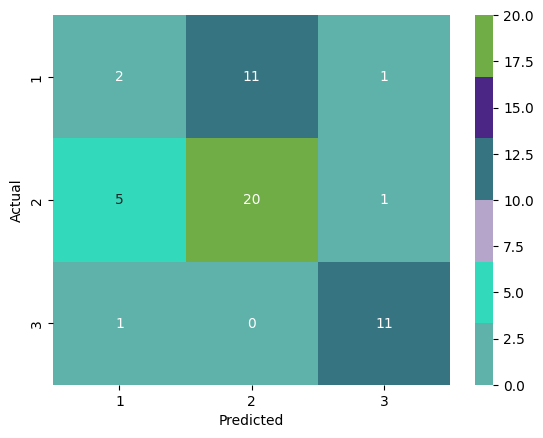

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



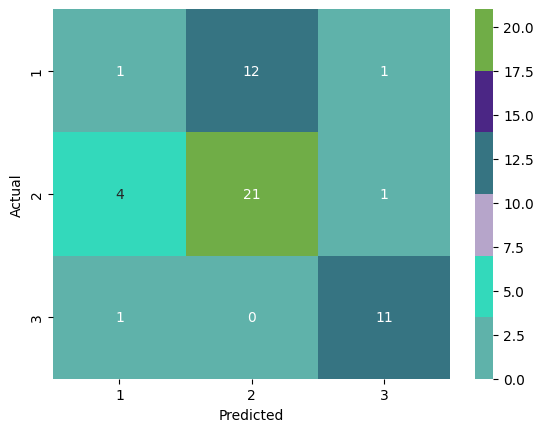

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



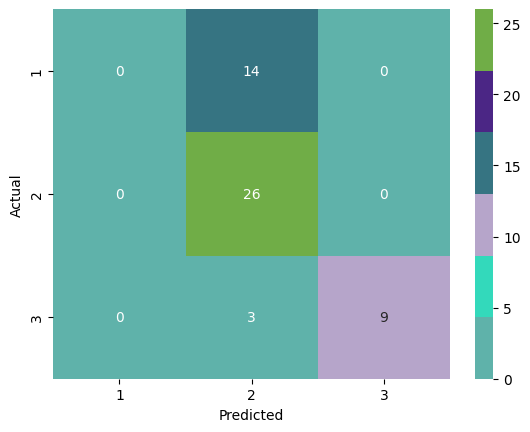

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



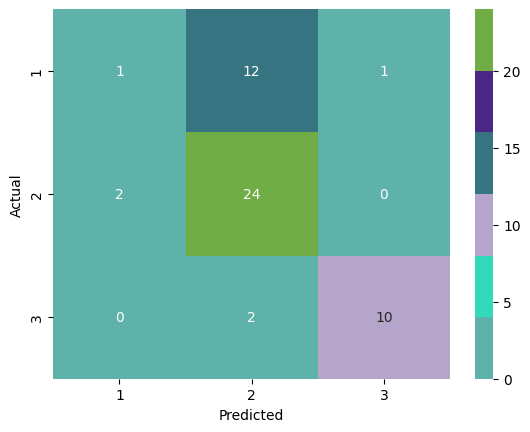

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



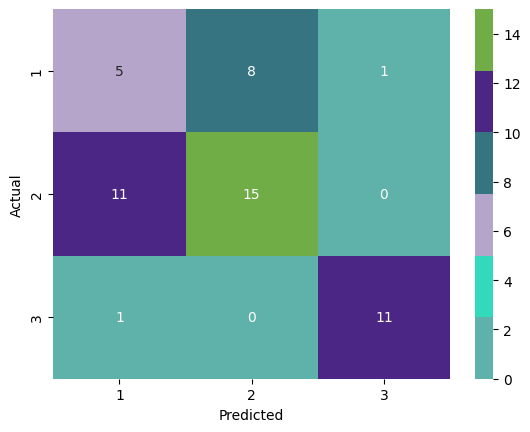

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



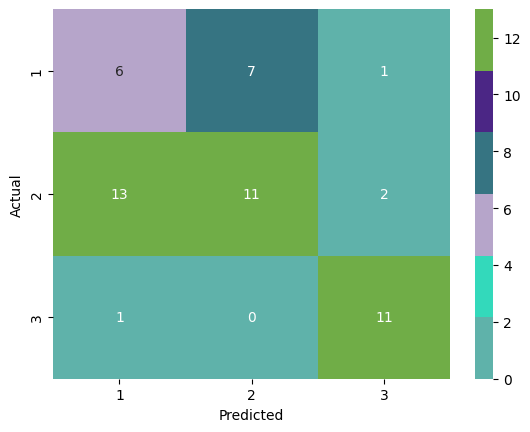

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



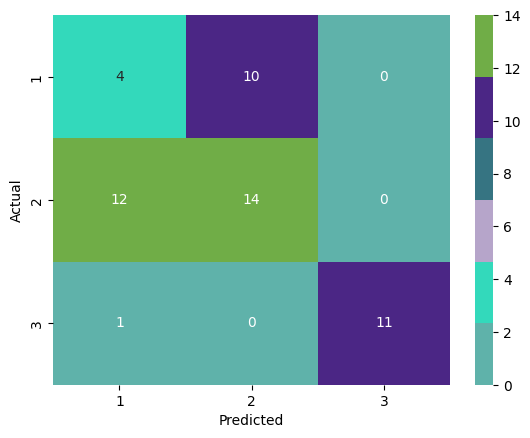

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df4, df=Resultados_4)

In [ ]:
Resultados_4

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.634615,0.625865,0.634615,0.591034
1,Bernoulli NB,bow,0.711538,0.685897,0.711538,0.639005
2,Regresion Logistica,bow,0.596154,0.618343,0.596154,0.601911
3,SVM lineal,bow,0.557692,0.550734,0.557692,0.554024
4,SVM polinomico,bow,0.519231,0.522398,0.519231,0.507051
5,SVM Kernel rbf,bow,0.538462,0.602849,0.538462,0.538531
6,SVM Kernel Sigmoid,bow,0.557692,0.660010,0.557692,0.558118
7,Random Forest d_20,bow,0.634615,0.612551,0.634615,0.621608
8,Random Forest d_50,bow,0.557692,0.591912,0.557692,0.569719
9,Multinomial NB,tfidf,0.711538,0.547842,0.711538,0.608795


OBSERVACIONES:
Analizando los resultados el modelo *SVM Kernel Sigmoid* vectorizado con TF-IDF tuvo mejor rendimiento de manera general en las tres variables de salida, tiene un F1: 0.636 y precisión: 0.626

Aunque de manera general no es el que tiene el mejor rendimiento numérico, ya que los modelos *SVM Kernel RBF (TFIDF)*, *Bernolli NB* tanto para Bag_of_Words cómo para TFIDF,tuvieron un F1:0.639 y Precisión:0.686. Si se revisa la matriz de confusión, la clase 1 no la está prediciendo correctamente, el modelo seleccionado tiene una mejor precisión considerando la proporcipon de datos.


### SELECCIÓN DE MODELO PARA PREGUNTA 5

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_5= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



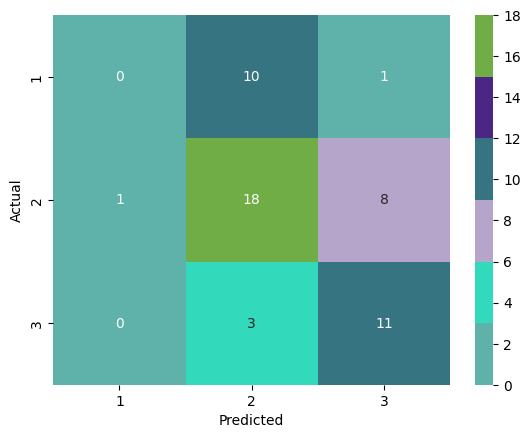

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



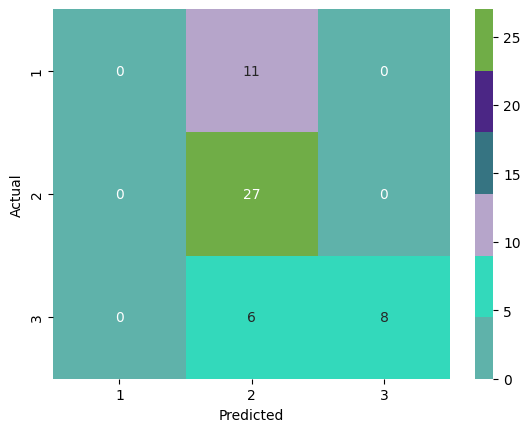

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



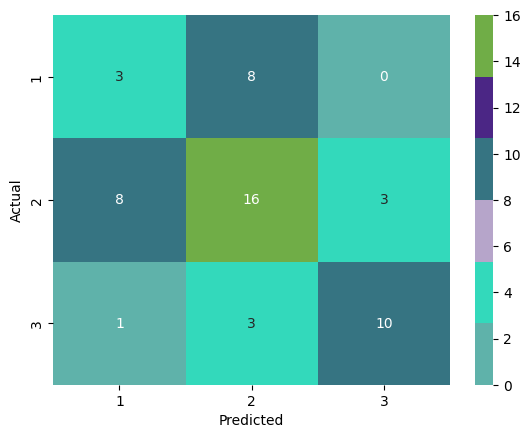

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



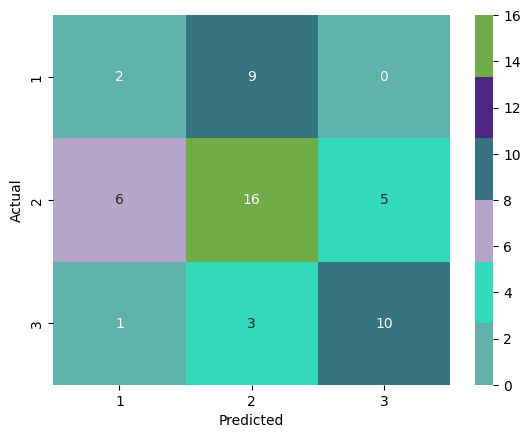

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



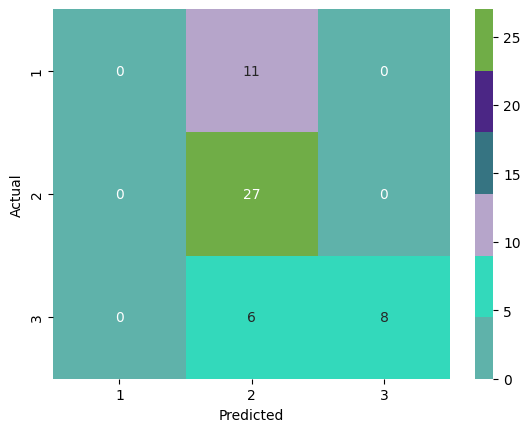

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



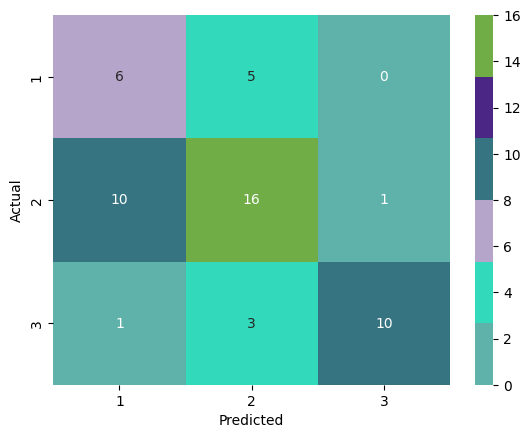

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



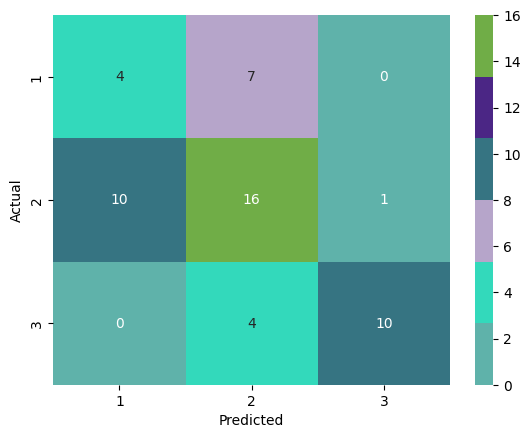

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



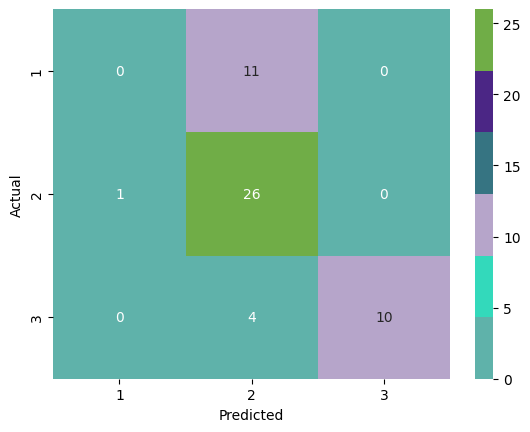

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



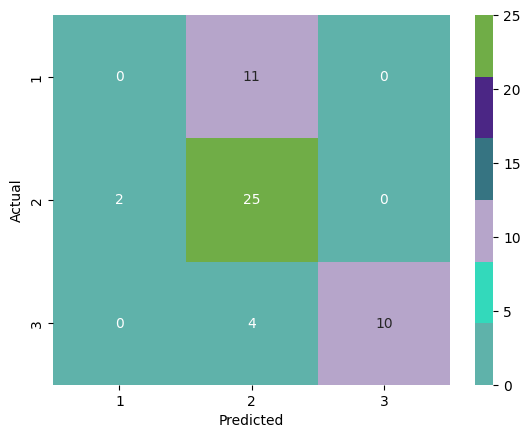

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



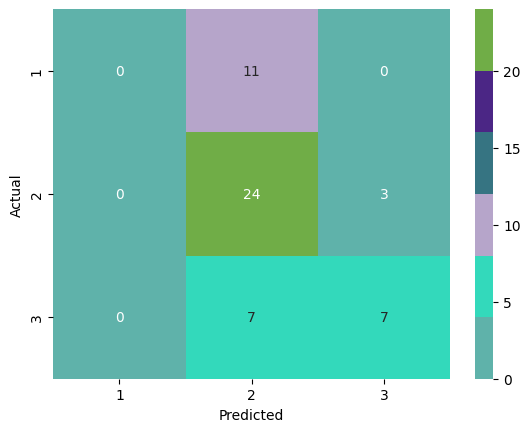

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



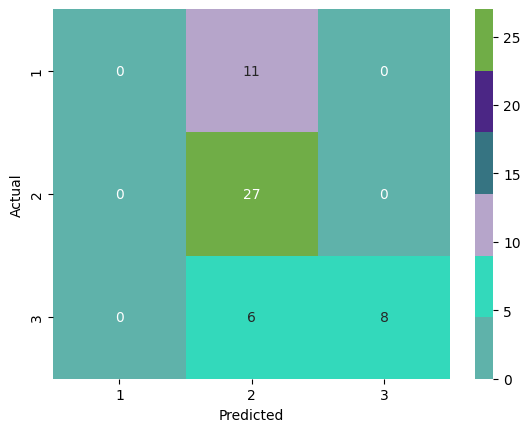

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



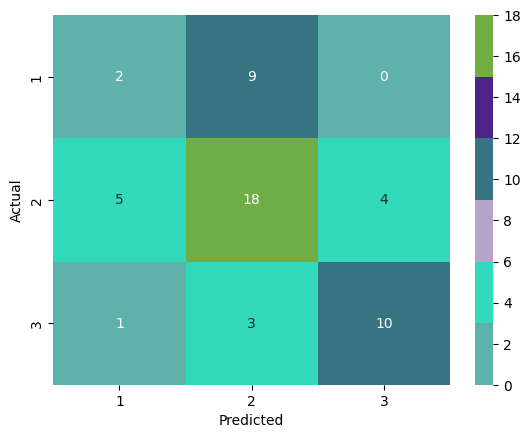

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



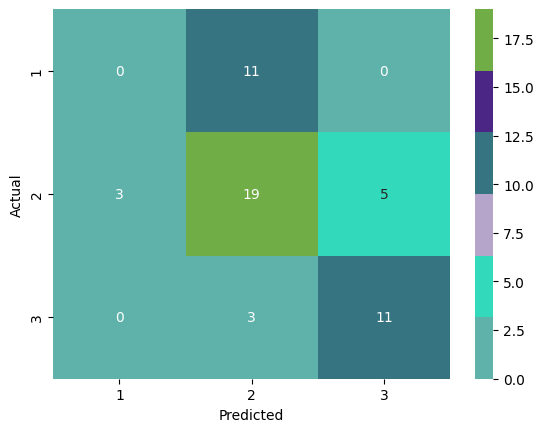

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



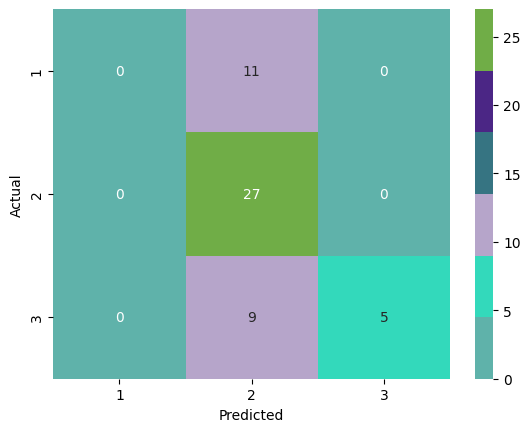

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



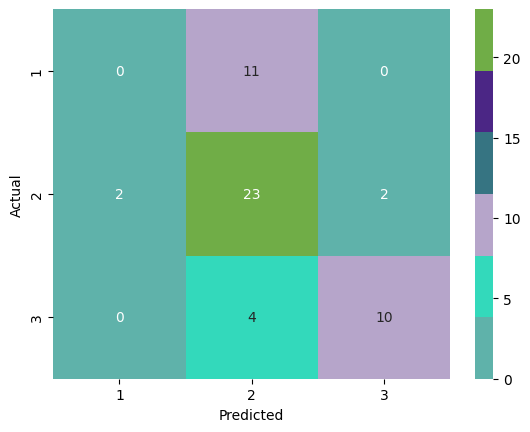

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



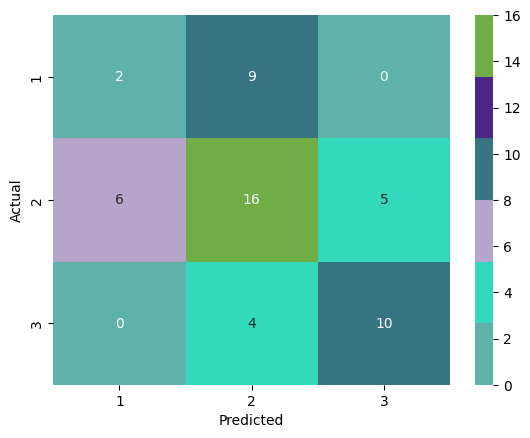

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



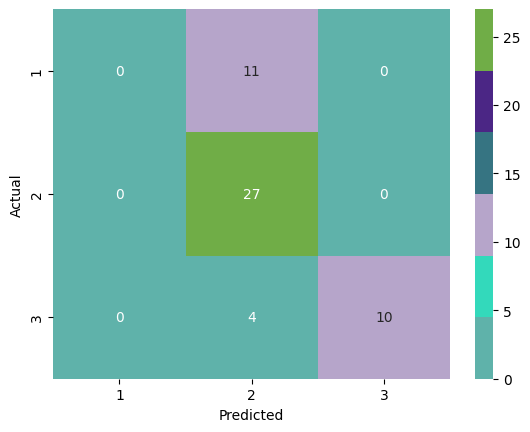

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



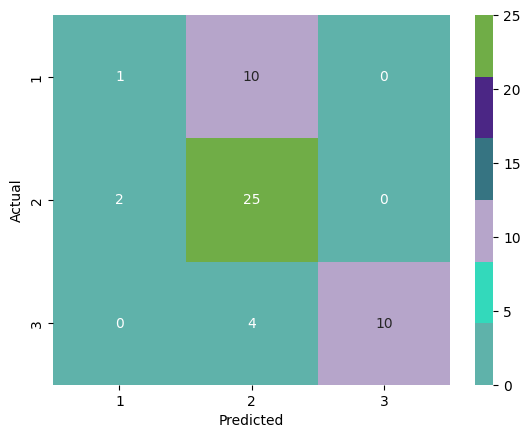

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



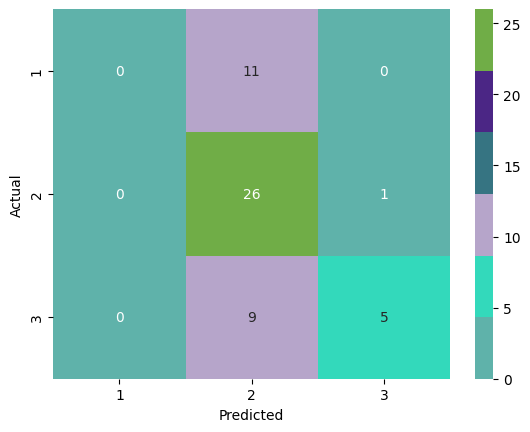

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



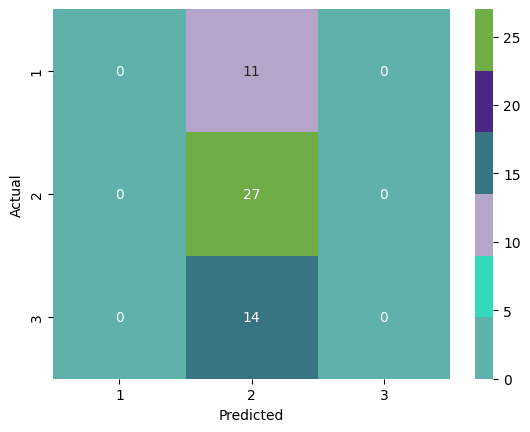

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



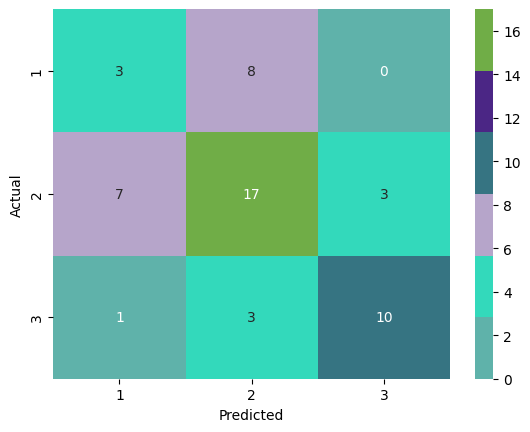

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



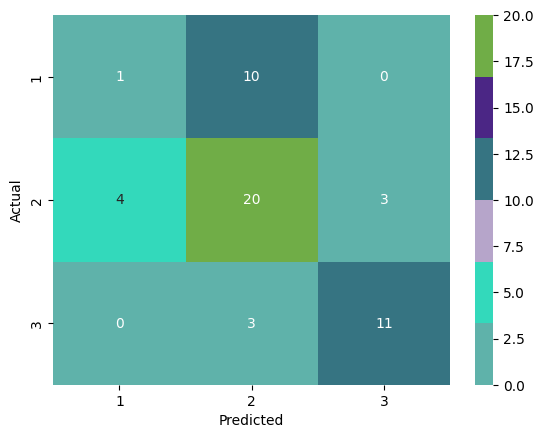

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



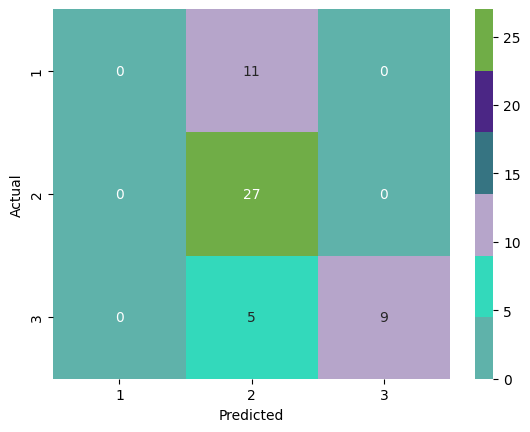

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



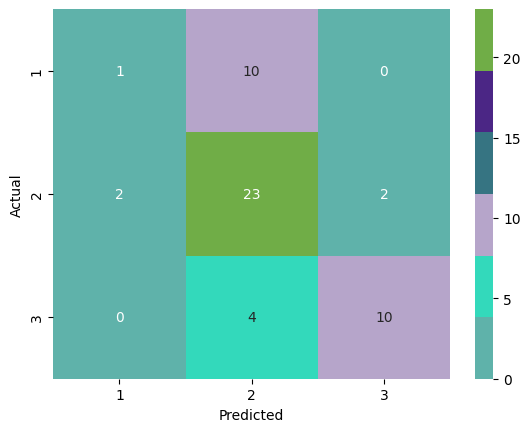

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



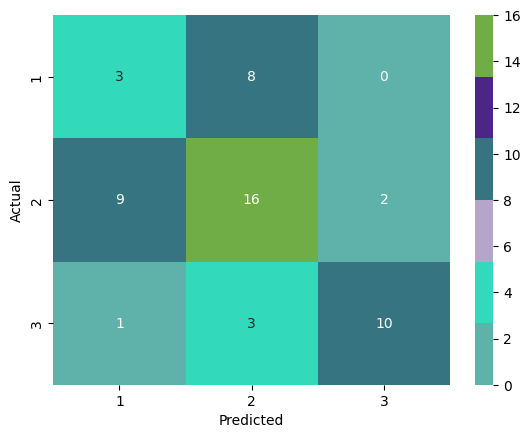

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



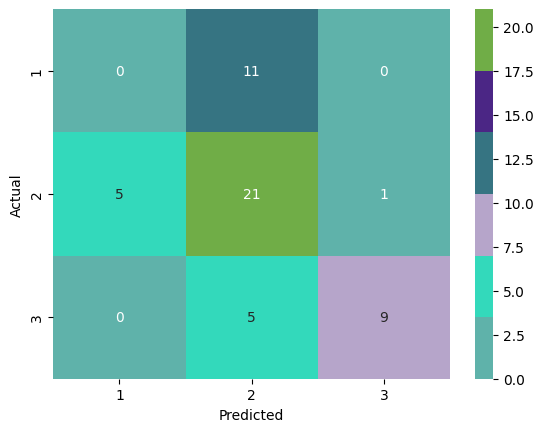

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



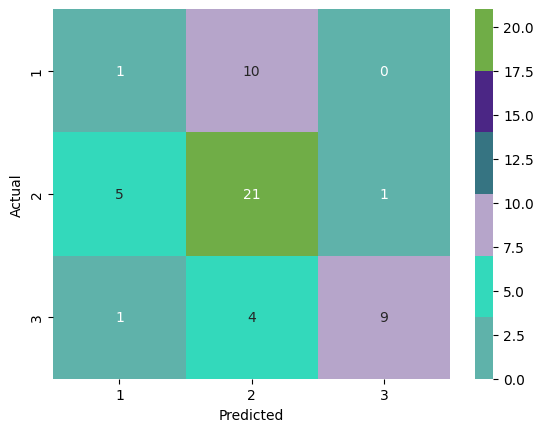

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df5, df=Resultados_5)

In [ ]:
Resultados_5

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.557692,0.449566,0.557692,0.496489
1,Bernoulli NB,bow,0.673077,0.587850,0.673077,0.590712
2,Regresion Logistica,bow,0.557692,0.567678,0.557692,0.562306
3,SVM lineal,bow,0.538462,0.523199,0.538462,0.530082
4,SVM polinomico,bow,0.673077,0.587850,0.673077,0.590712
5,SVM Kernel rbf,bow,0.615385,0.665570,0.615385,0.631836
6,SVM Kernel Sigmoid,bow,0.576923,0.612887,0.576923,0.590769
7,Random Forest d_20,bow,0.692308,0.598499,0.692308,0.621418
8,Random Forest d_50,bow,0.673077,0.593750,0.673077,0.611845
9,Multinomial NB,tfidf,0.596154,0.485165,0.596154,0.518255


OBSERVACIONES:
Analizando los resultados el modelo *Random Forest_d50* vectorizado con TF-IDF tuvo mejor rendimiento de manera general en 2 de las tres variables de salida, tiene un F1: 0.648 y precisión: 0.672


### SELECCIÓN DE MODELO PARA PREGUNTA 6

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_6= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



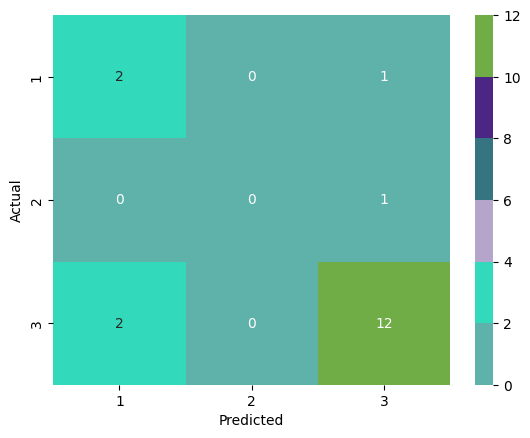

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



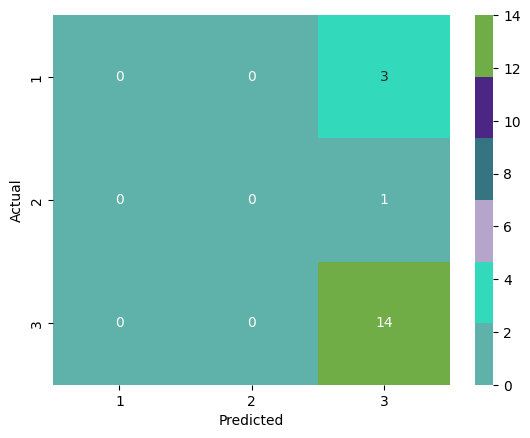

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



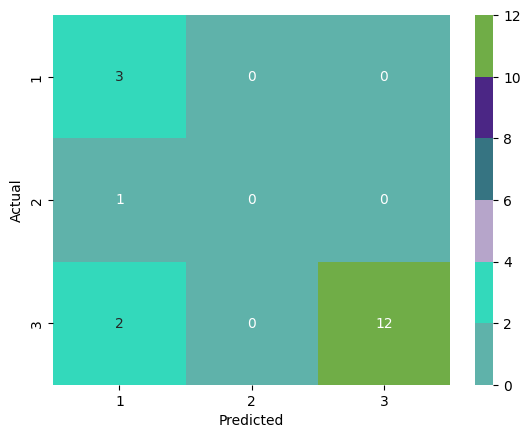

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



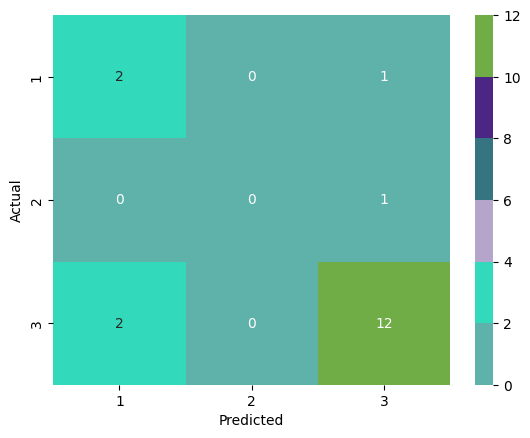

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



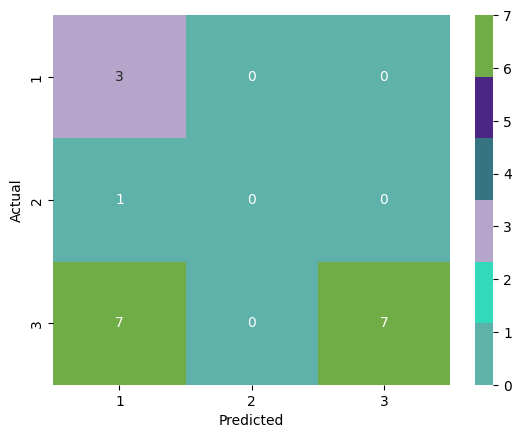

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



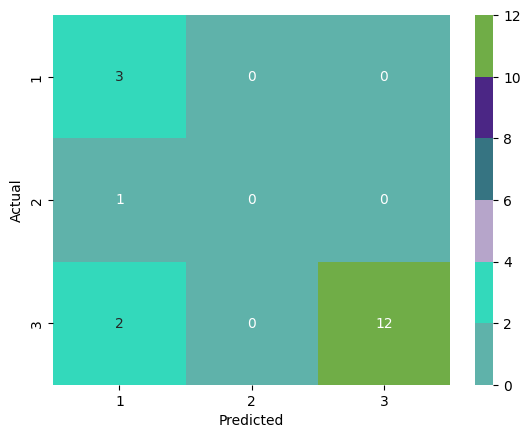

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



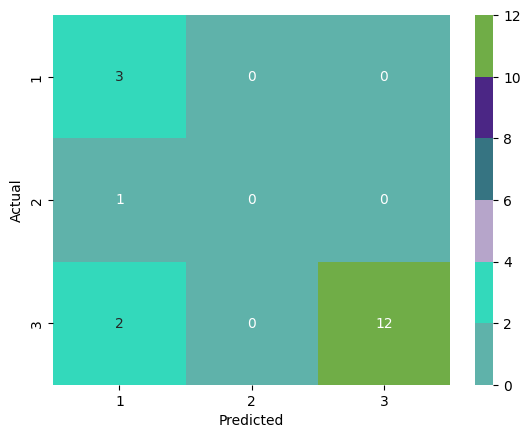

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



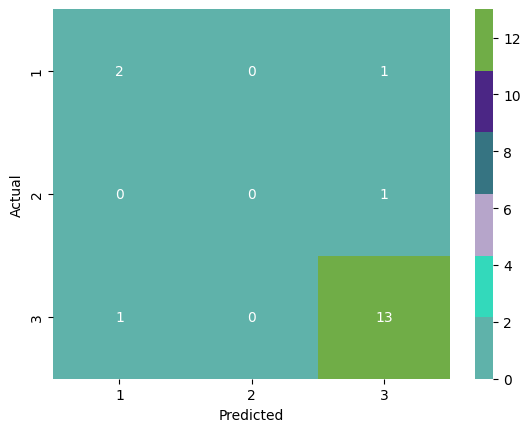

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



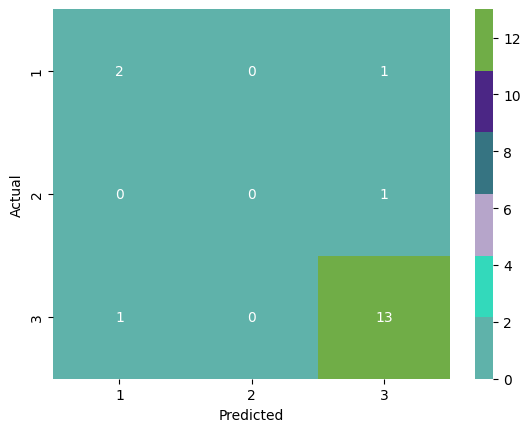

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



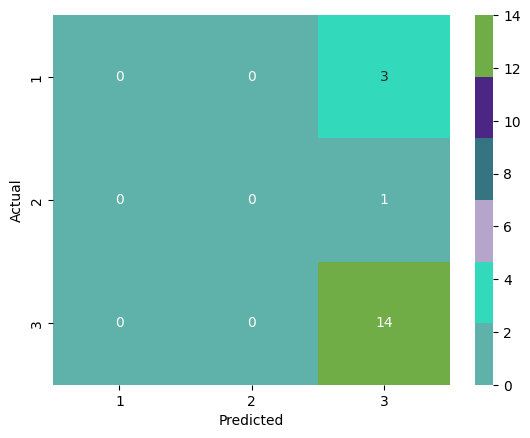

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



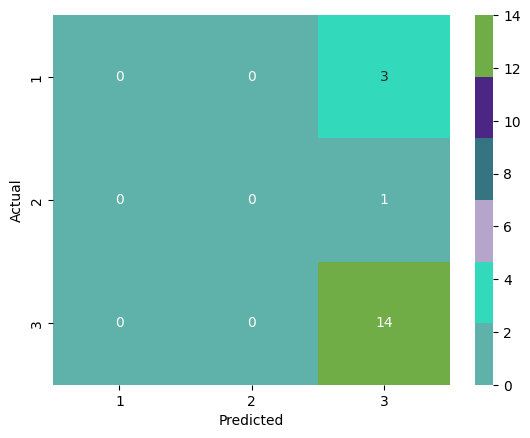

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



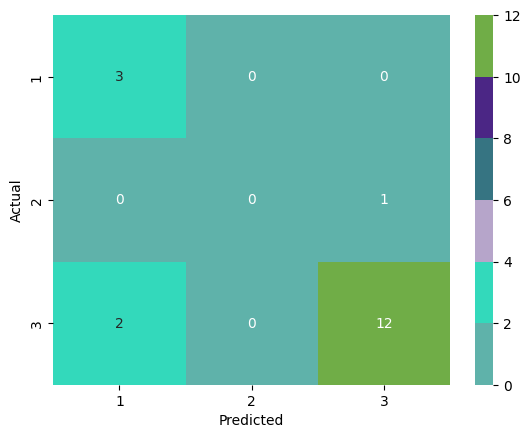

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



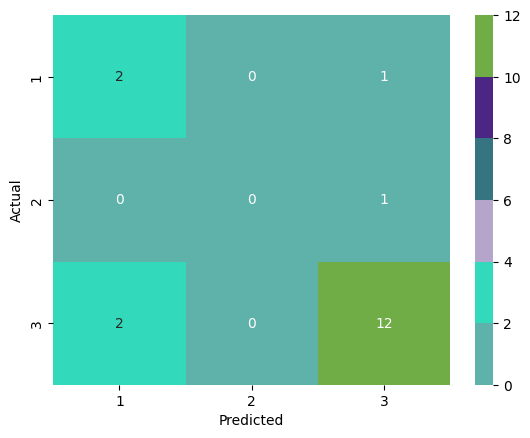

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



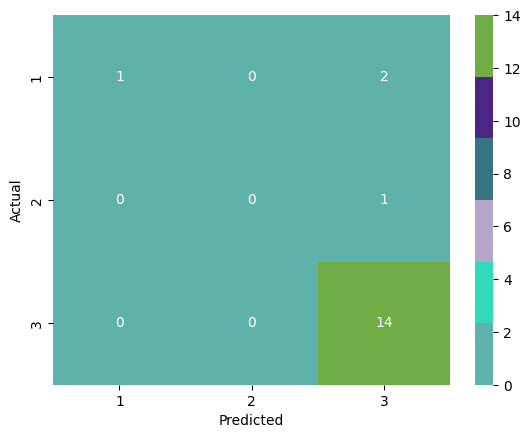

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



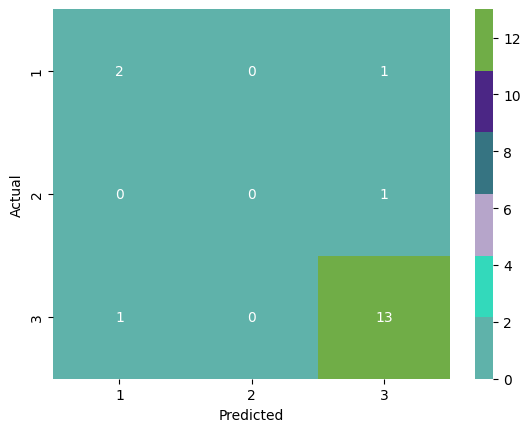

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



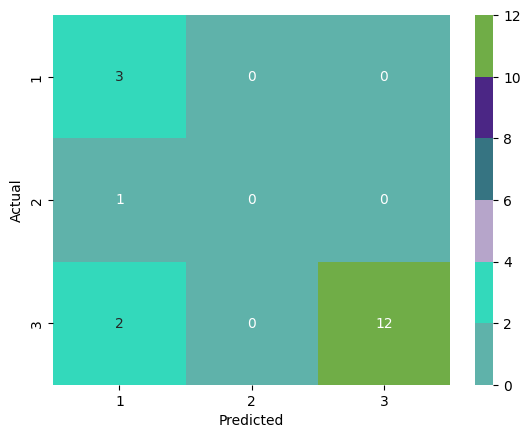

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



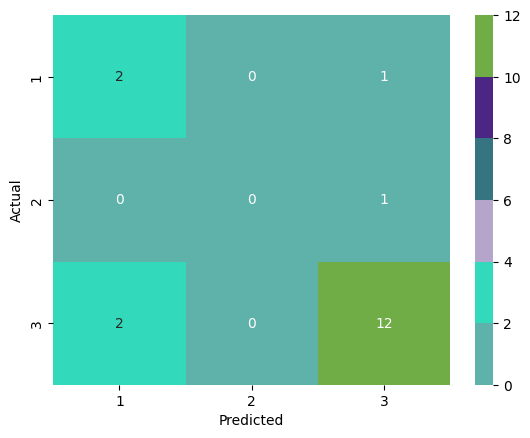

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



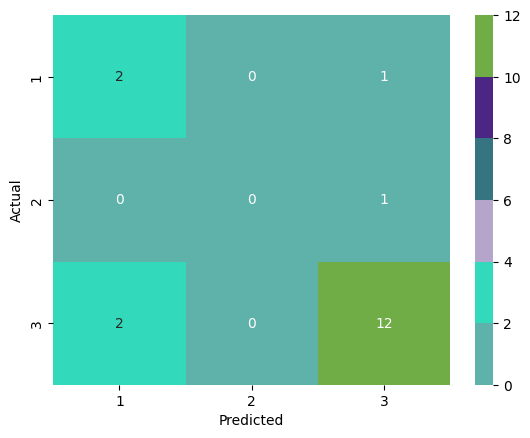

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



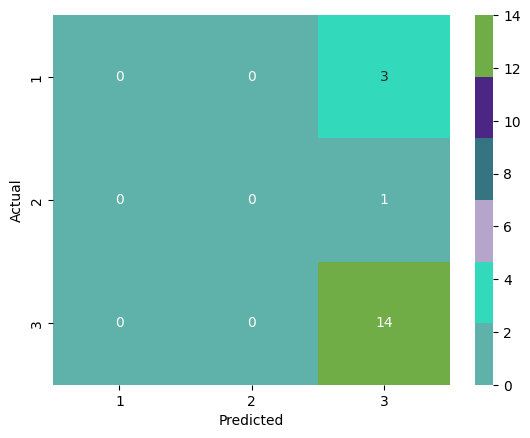

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



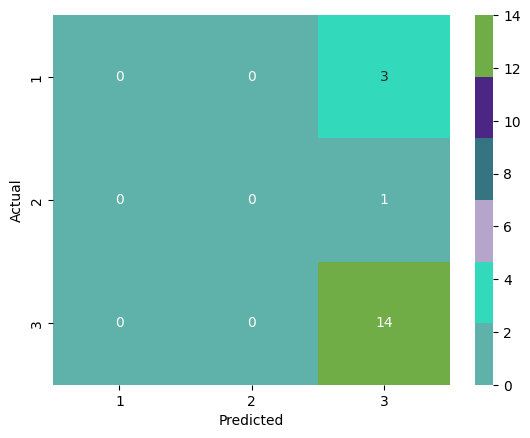

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



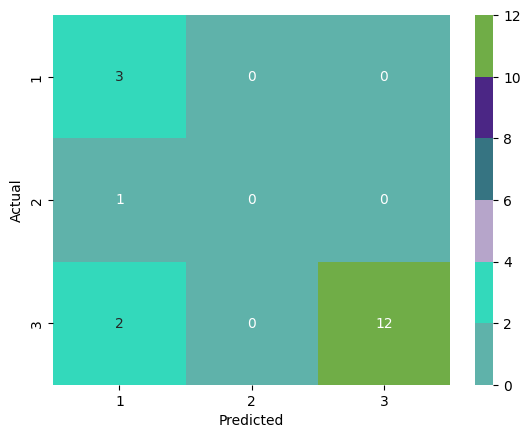

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



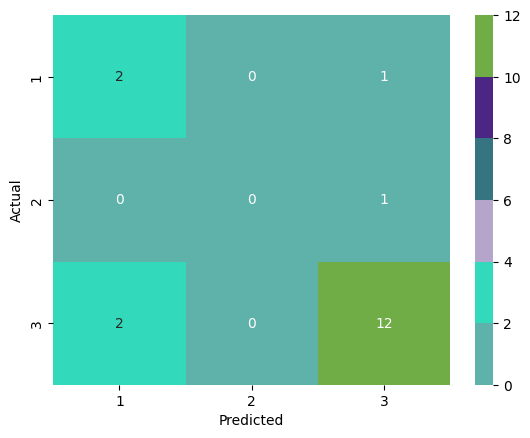

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



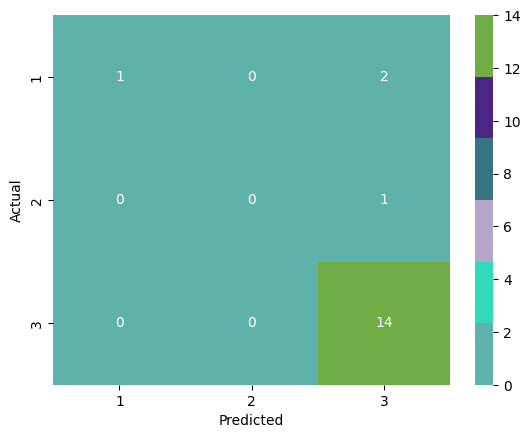

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



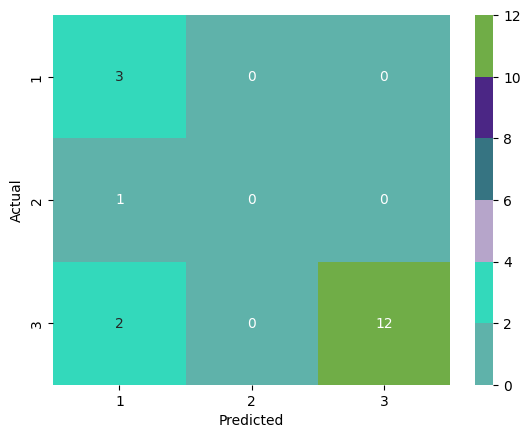

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



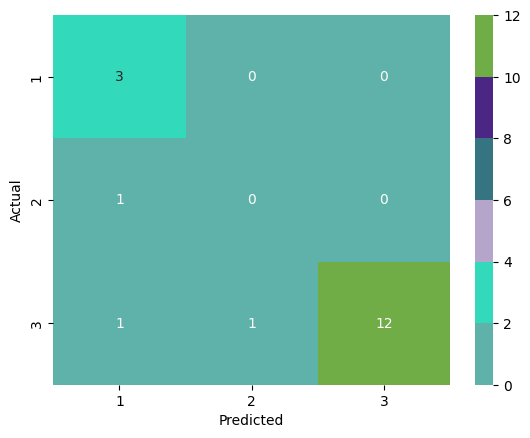

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



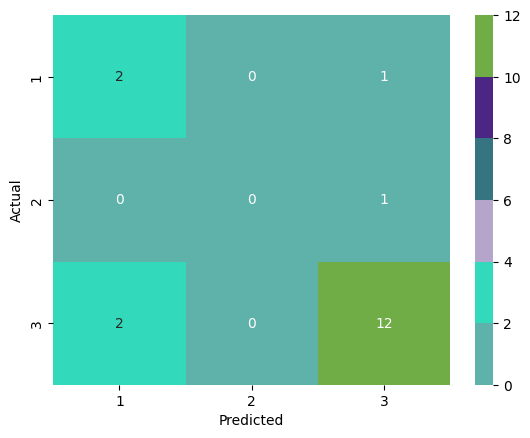

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



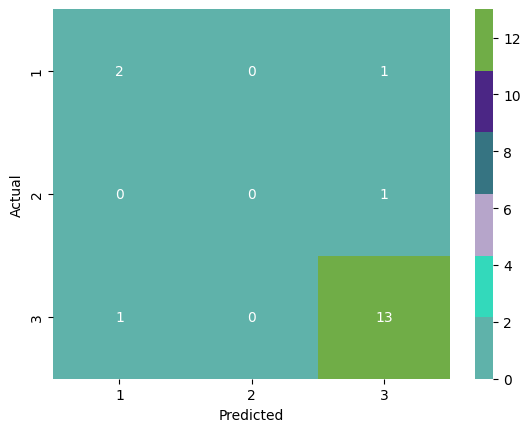

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df6, df=Resultados_6)

In [ ]:
Resultados_6

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.777778,0.750000,0.777778,0.761905
1,Bernoulli NB,bow,0.777778,0.604938,0.777778,0.680556
2,Regresion Logistica,bow,0.833333,0.861111,0.833333,0.829060
3,SVM lineal,bow,0.777778,0.750000,0.777778,0.761905
4,SVM polinomico,bow,0.555556,0.823232,0.555556,0.589947
5,SVM Kernel rbf,bow,0.833333,0.861111,0.833333,0.829060
6,SVM Kernel Sigmoid,bow,0.833333,0.861111,0.833333,0.829060
7,Random Forest d_20,bow,0.833333,0.785185,0.833333,0.808429
8,Random Forest d_50,bow,0.833333,0.785185,0.833333,0.808429
9,Multinomial NB,tfidf,0.777778,0.604938,0.777778,0.680556


OBSERVACIONES:

El modelo que tuvo mejor rendimiento fue SVM Kernel Sigmoid con la vectorización (hash) con un F1: 0.8429

*A partir de esta pregunta en adelante, se cuenta cón sólo 86 datos para entrenar porque las personas solicitantes al crédito no suelen responder estas preguntas, por lo que, sería importante verificar la necesidad de que sean respondidas.
*También se observa en las matrices de confusión que al haber un sesgo importante para el score 2, el modelo no puede aprender a identificarlo.


### SELECCIÓN DE MODELO PARA PREGUNTA 7

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_7= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



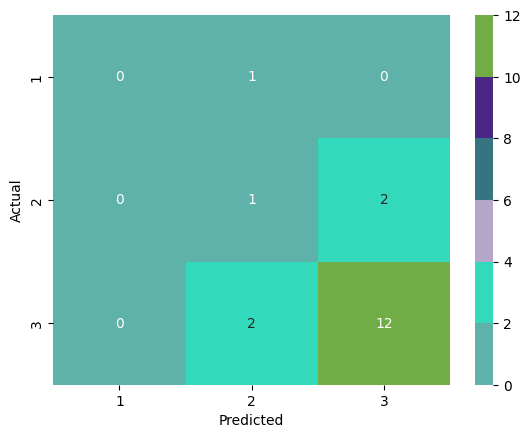

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



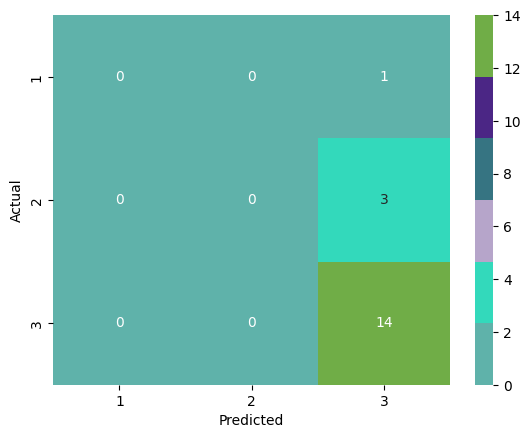

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



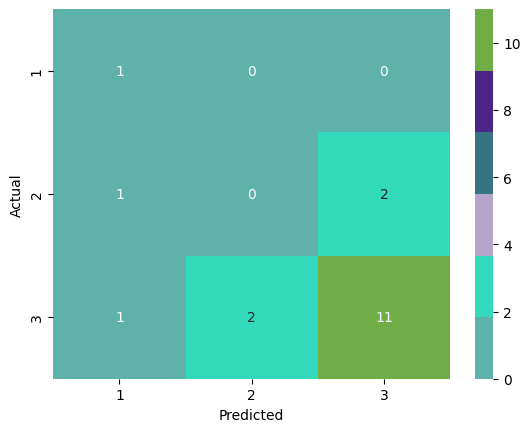

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



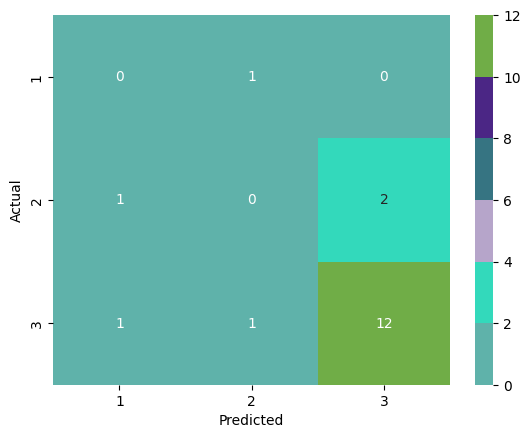

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



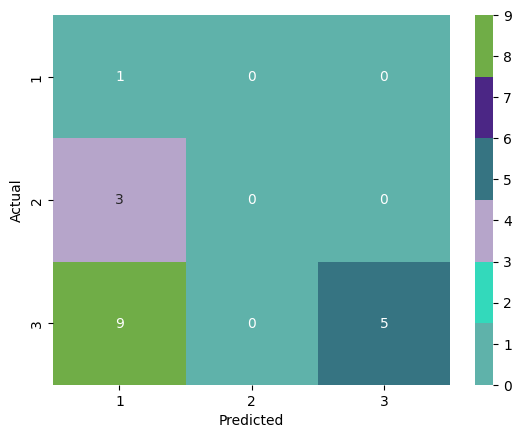

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



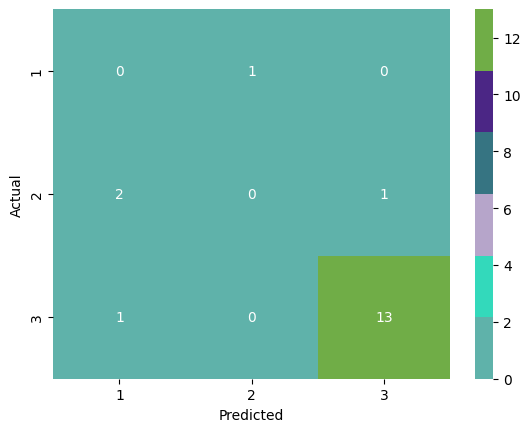

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



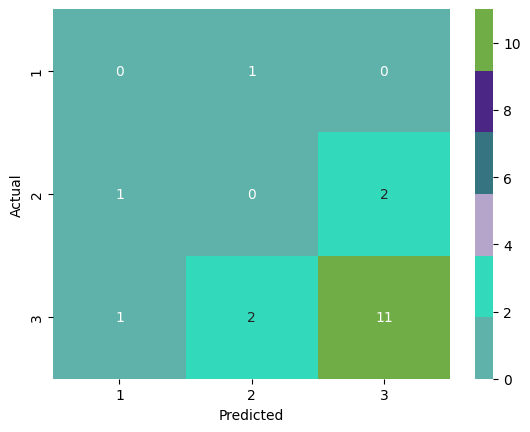

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



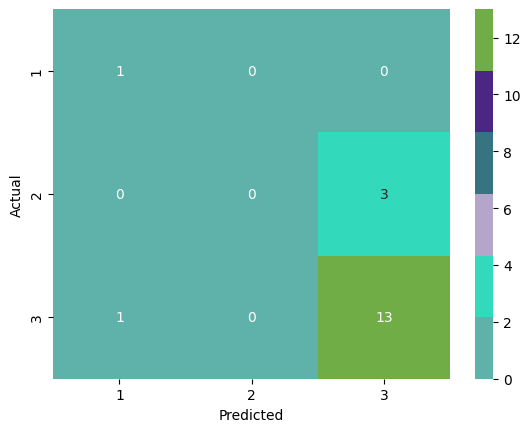

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



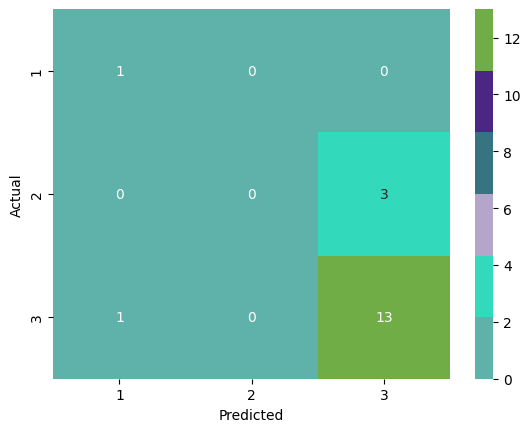

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



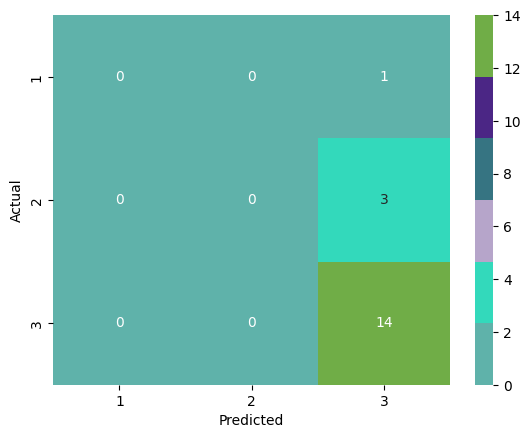

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



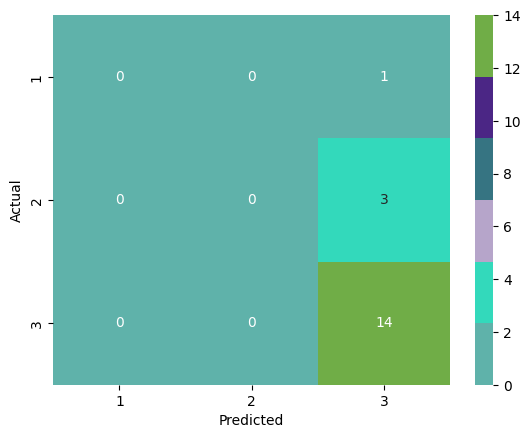

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



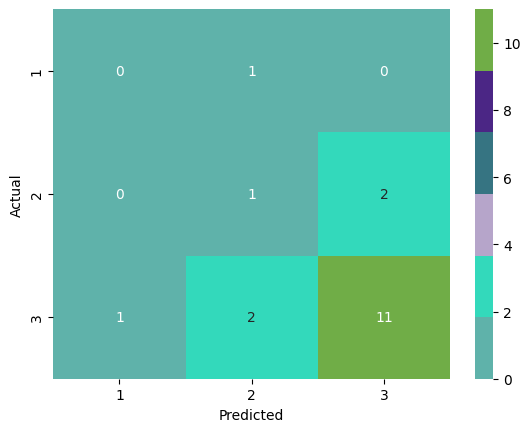

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



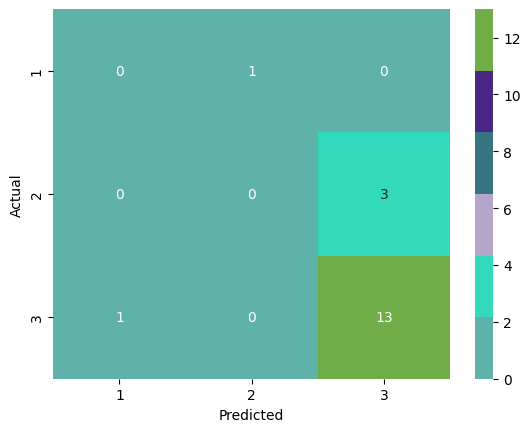

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



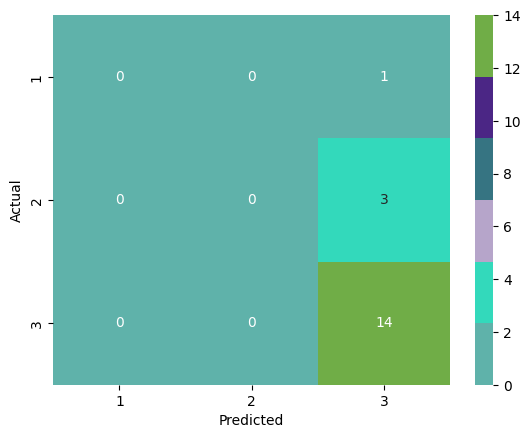

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



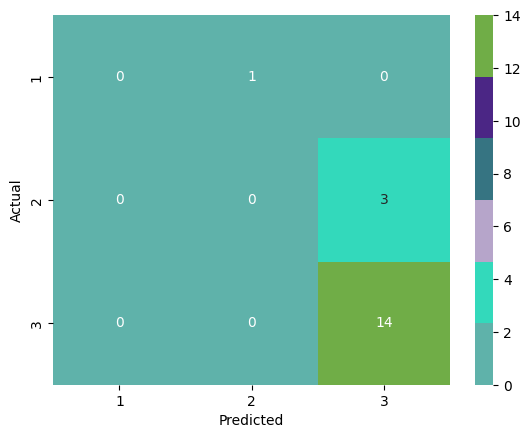

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



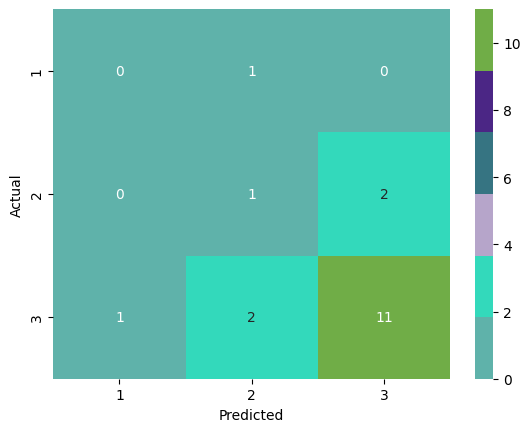

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



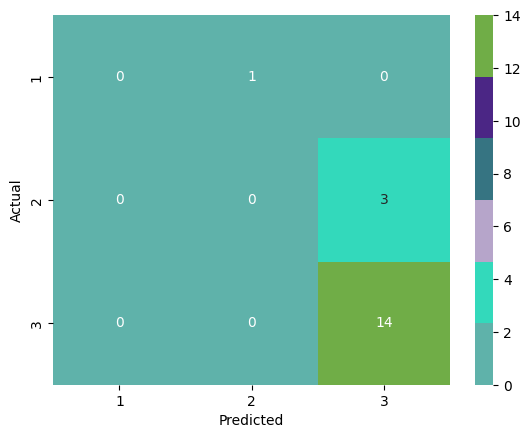

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



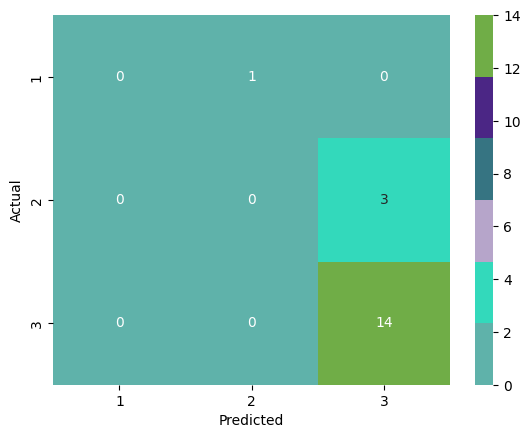

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



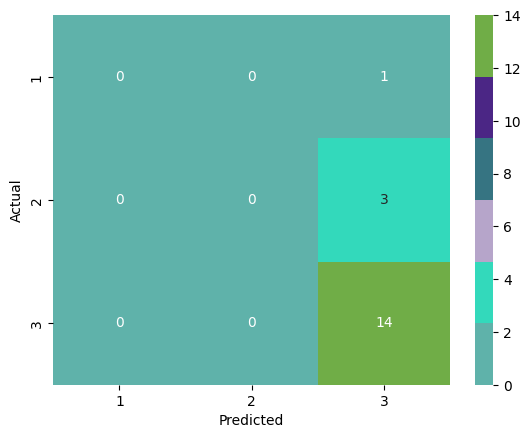

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



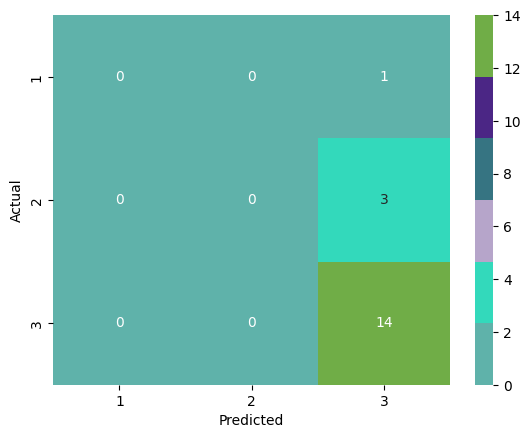

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



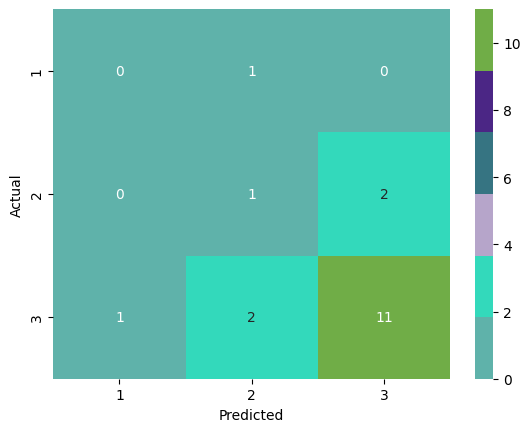

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



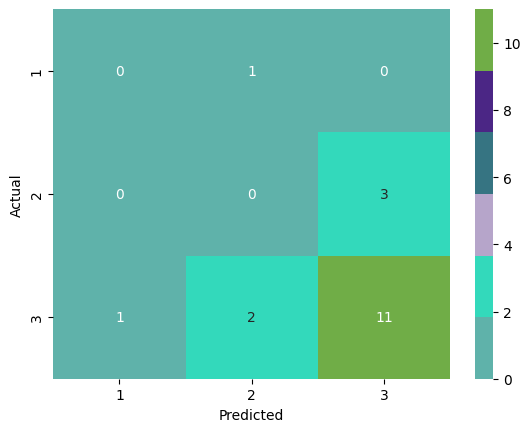

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



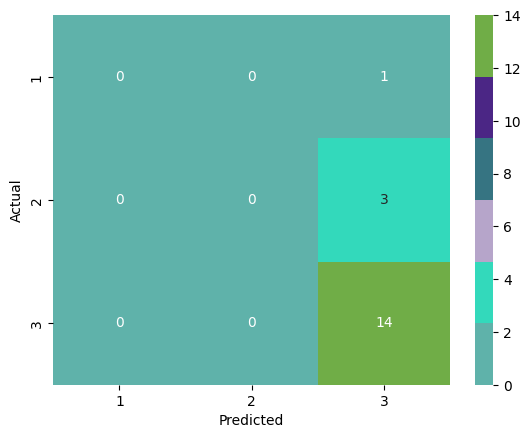

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



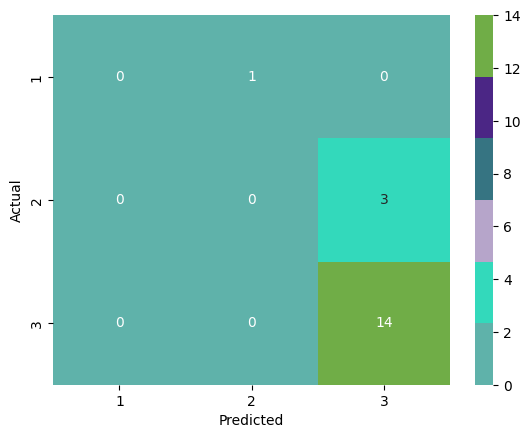

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



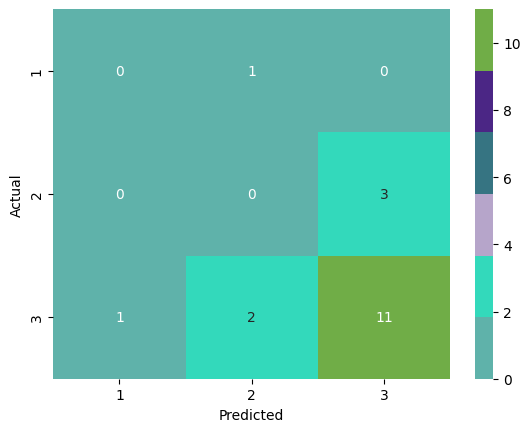

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



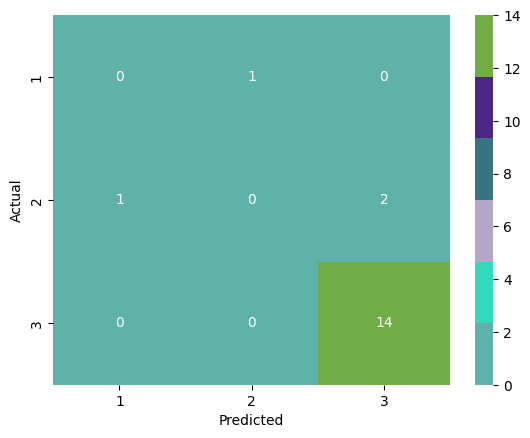

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



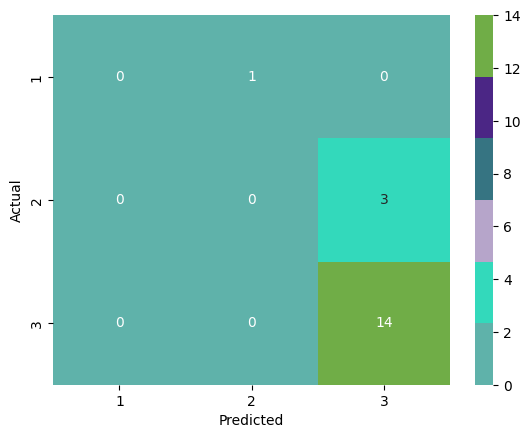

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df7, df=Resultados_7)

In [ ]:
Resultados_7

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.722222,0.708333,0.722222,0.714286
1,Bernoulli NB,bow,0.777778,0.604938,0.777778,0.680556
2,Regresion Logistica,bow,0.666667,0.676638,0.666667,0.661523
3,SVM lineal,bow,0.666667,0.666667,0.666667,0.666667
4,SVM polinomico,bow,0.333333,0.782051,0.333333,0.417293
5,SVM Kernel rbf,bow,0.722222,0.722222,0.722222,0.722222
6,SVM Kernel Sigmoid,bow,0.611111,0.658120,0.611111,0.633745
7,Random Forest d_20,bow,0.777778,0.659722,0.777778,0.711111
8,Random Forest d_50,bow,0.777778,0.659722,0.777778,0.711111
9,Multinomial NB,tfidf,0.777778,0.604938,0.777778,0.680556


OBSERVACIONES:
Es complicado poder determinar cual modelo tuvo mejor rendimiento, ya que, al no haber suficientes datos, el modelo no es tan preciso, por ejemplo: el que tuvo mayor score en F1 fue SVM Kernel rbf (Bag_of_Words) con 0.7222, sin embargo, se puede apreciar para el score 1 y 2 no hubo ningún acierto, por lo que el modelo no puede emplearse para evaluar.

También se encuentran con el mismo score Los modelos de Random Forest tanto con 20 cómo con 50 ramas para la vectorización con Bag_of_Words, con un score en F1: 0.7111, se podría decir que tuvo una mejor precisión al detectar los score en 1, sin embargo, habría que entrenarlo con una cantidad más grande de datos para comprobarlo


### SELECCIÓN DE MODELO PARA PREGUNTA 8

In [ ]:
# Crear un nuevo DataFrame para almacenar los resultados
Resultados_8= pd.DataFrame(columns=['Model', 'Vect', 'Accuracy', 'Precision',
                                   'Recall', 'F1-score'])

Confusion Matrix for Model "Multinomial NB" with method "bow" 



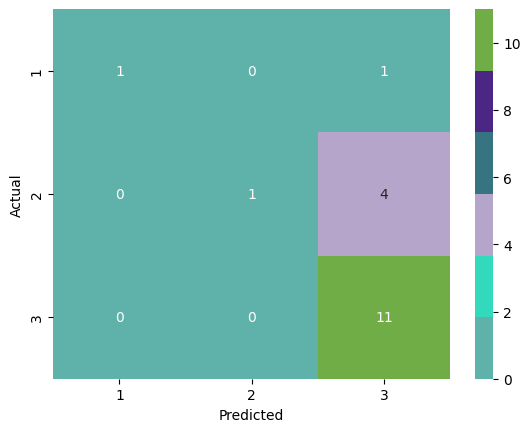

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "bow" 



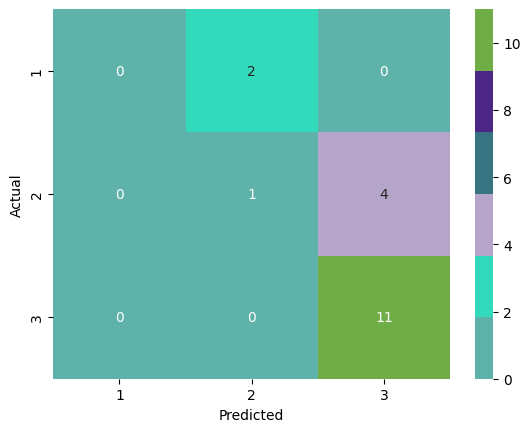

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "bow" 



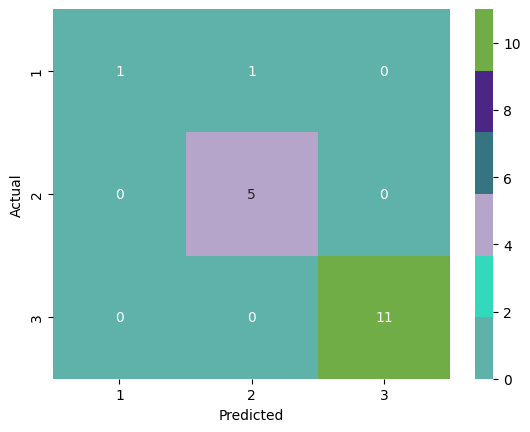

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "bow" 



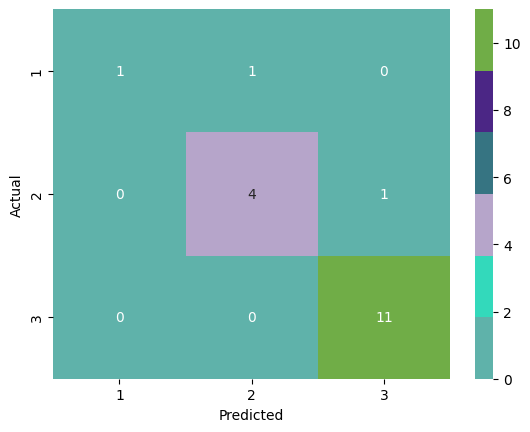

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "bow" 



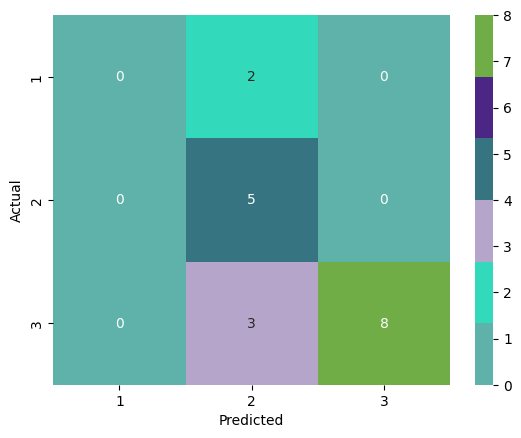

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "bow" 



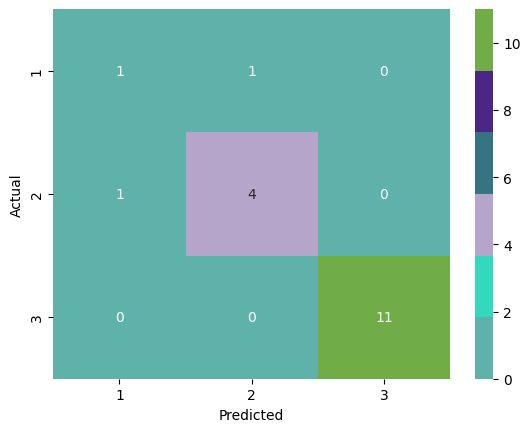

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "bow" 



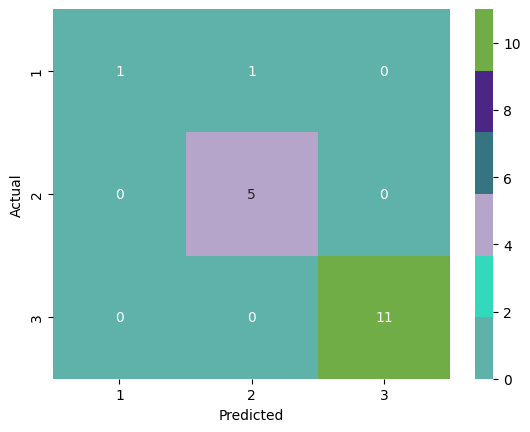

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "bow" 



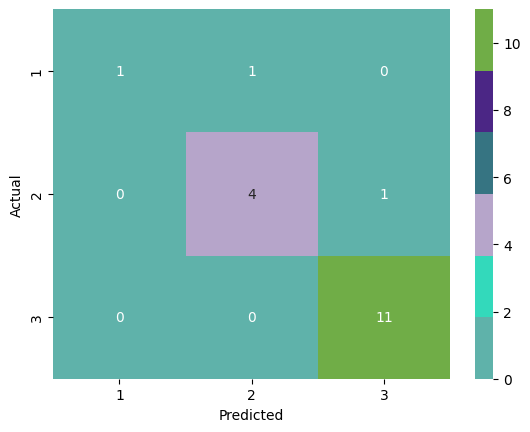

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "bow" 



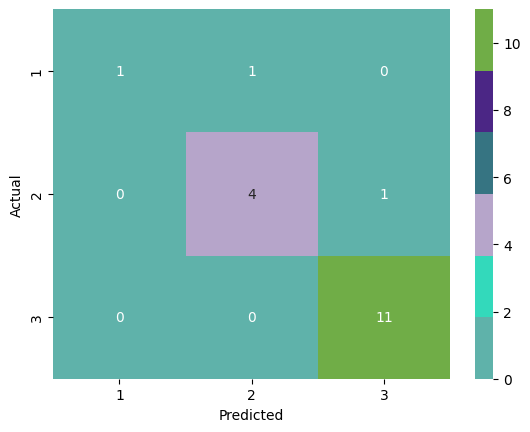

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "tfidf" 



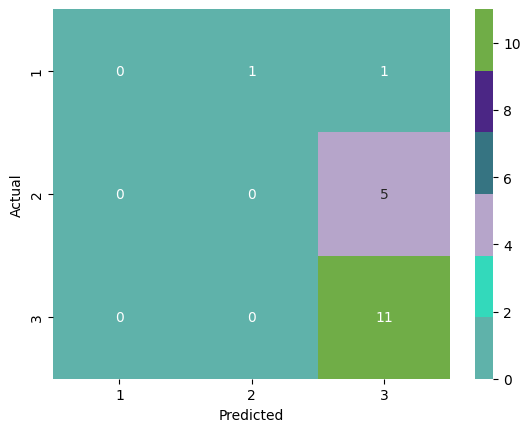

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "tfidf" 



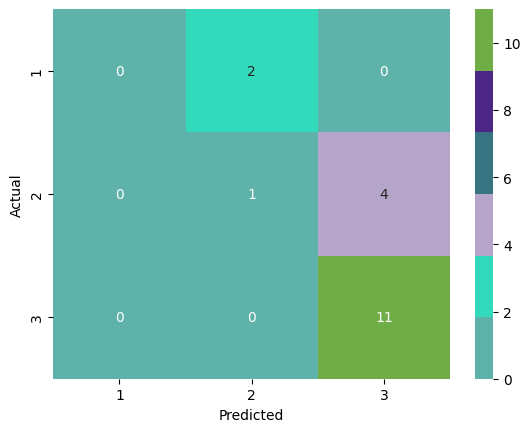

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "tfidf" 



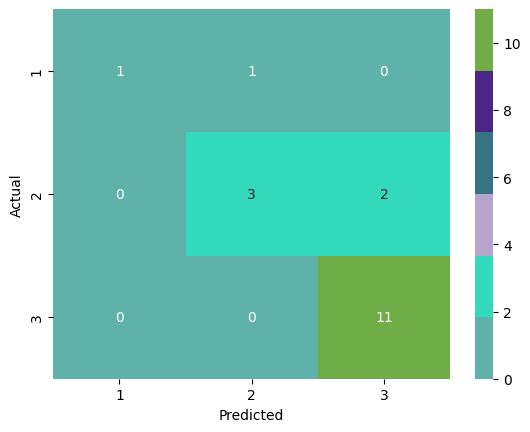

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "tfidf" 



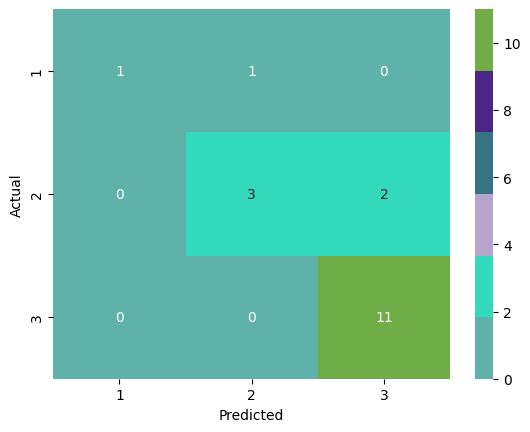

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "tfidf" 



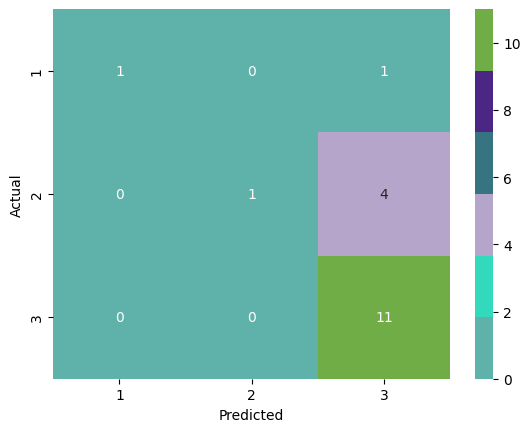

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "tfidf" 



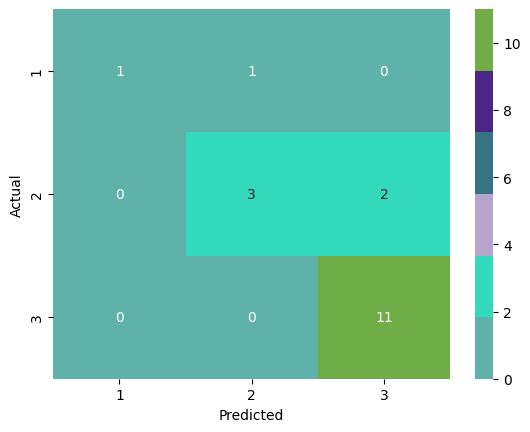

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "tfidf" 



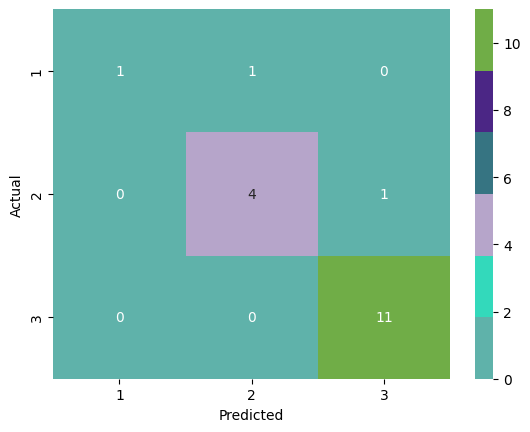

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "tfidf" 



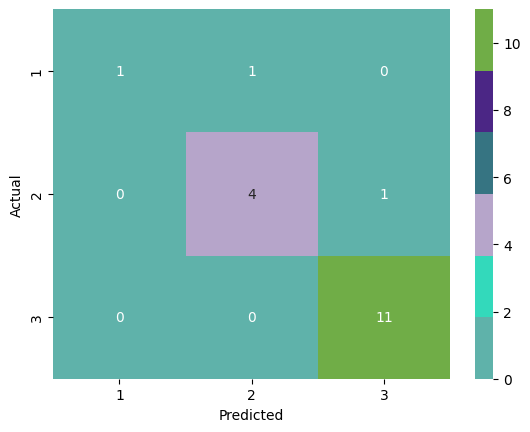

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "tfidf" 



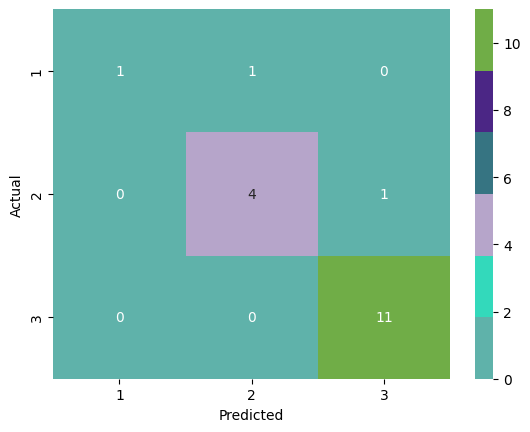

---------------------------------------------------------------------- 

Confusion Matrix for Model "Multinomial NB" with method "hash" 



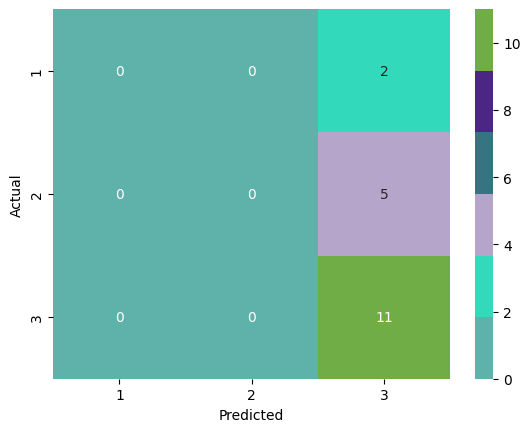

---------------------------------------------------------------------- 

Confusion Matrix for Model "Bernoulli NB" with method "hash" 



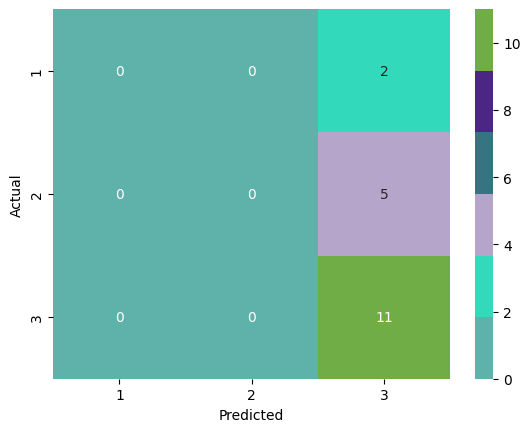

---------------------------------------------------------------------- 

Confusion Matrix for Model "Regresion Logistica" with method "hash" 



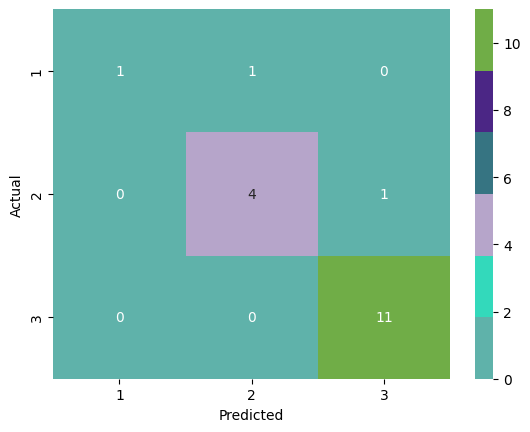

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM lineal" with method "hash" 



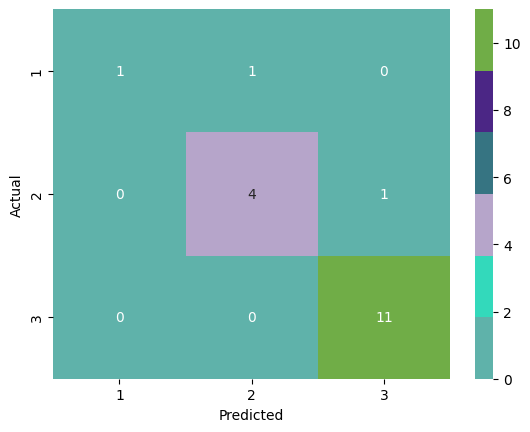

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM polinomico" with method "hash" 



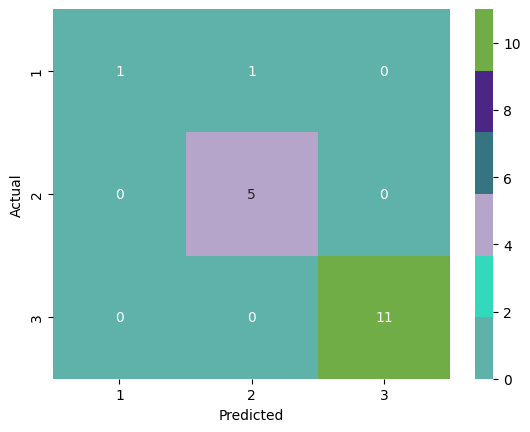

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel rbf" with method "hash" 



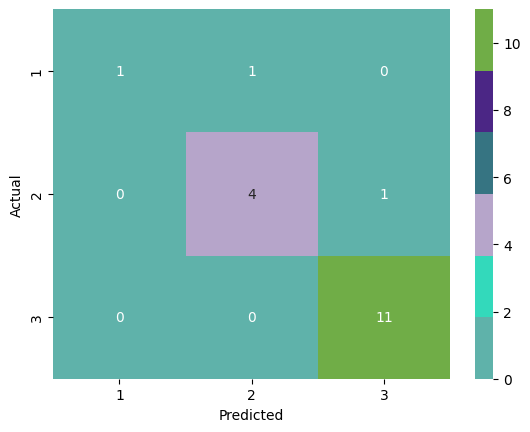

---------------------------------------------------------------------- 

Confusion Matrix for Model "SVM Kernel Sigmoid" with method "hash" 



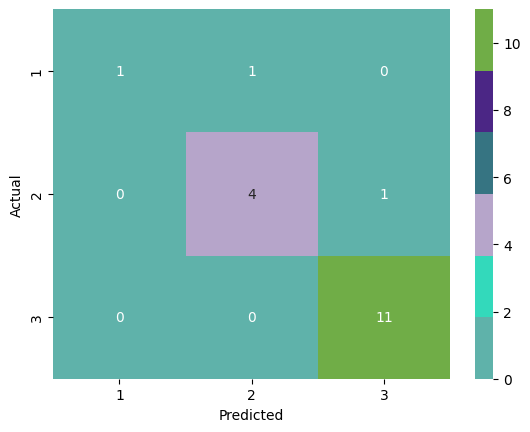

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_20" with method "hash" 



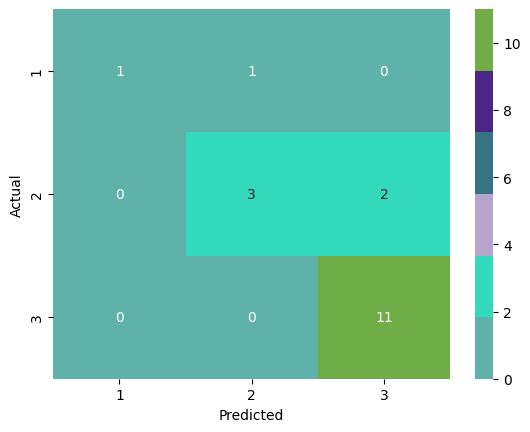

---------------------------------------------------------------------- 

Confusion Matrix for Model "Random Forest d_50" with method "hash" 



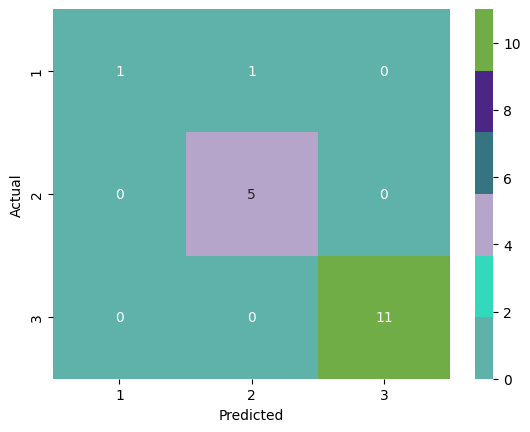

---------------------------------------------------------------------- 



In [ ]:
#Iterando para obtener dataframe con las métricas de cada método de vectorización, algoritmo de aprendizaje

for key, vector in vectorizadores.items():
  for k, model in clasificadores.items():
    pipeline(vect=vector, name_v=key, algoritm=model, name=k, pregunta=df8, df=Resultados_8)

In [ ]:
Resultados_8

,Model,Vect,Accuracy,Precision,Recall,F1-score
0,Multinomial NB,bow,0.722222,0.809028,0.722222,0.664609
1,Bernoulli NB,bow,0.666667,0.540741,0.666667,0.586538
2,Regresion Logistica,bow,0.944444,0.953704,0.944444,0.937710
3,SVM lineal,bow,0.888889,0.893519,0.888889,0.880837
4,SVM polinomico,bow,0.722222,0.750000,0.722222,0.699805
5,SVM Kernel rbf,bow,0.888889,0.888889,0.888889,0.888889
6,SVM Kernel Sigmoid,bow,0.944444,0.953704,0.944444,0.937710
7,Random Forest d_20,bow,0.888889,0.893519,0.888889,0.880837
8,Random Forest d_50,bow,0.888889,0.893519,0.888889,0.880837
9,Multinomial NB,tfidf,0.611111,0.395425,0.611111,0.480159


OBSERVACIONES:

Hay cuatro modelos con las métricas y las matrices de confución exactamente iguales, lo que hace imposible la detección del mejor modelo. Esto debido a que la data sólo cuenta con 86 datos, lo que la hace insuficiente para el entrenamiento adecuado del modelo. Los algoritmos son:

- Regresión Logística (Bow)
- SVM Kernel Sigmoid (Bow)
- SVM Polinómico (Hash)
- Random Forest d_50 (Hash)




---


# RECOMENDACIONES FINALES

Si bien el haber generado data sintética ha permitido mejorar el entrenamiento de los modelos hasta la pregunta 5, se recomienda recopilar más datos, no sólo en cantidad sino reales.

- También tomar una decisión con las preguntas que los solicitantes dejan en blanco, si realmente son relevantes, evitar que el solicitante del préstamo lo deje en blanco ó seleccionar las preguntas relevantes para aprobar un préstamo.

- De acuerdo a los modelos, el que tuvo mejor rendimiento fue el algoritmo Random Forest ya sea con una profundidad de 20 o  50. Y con las vectorizaciones BOW ó TFIDF. Y sólo en 2 preguntas abiertas SVM Kernel Sigmoid. Se recomienda concentrar la investigación en estos dos algoritmos y en las vectorizaciones BOW y TFIDF, ya que, la hash no tuvo relevancia.